In order to run this notebook you have to install the package `trump` in your computer that was created to make easier deal with the code base of this project. In the root folder of `trump` package you can run:
```python
pip3 install -e .
```
to install as a developer mode or
```python
pip3 install .
```
If you want, you can also bootstrap the virtual environment and run your notebook inside the virtual environment.
```bash
bash bootstrap-python-env.sh
source trump-env/bin/activate
jupyter notebook
```
This package was developed to make feasible read the code in the notebook, write tests for the functions and also to have a more manageable code base.

In [1]:
import sys
import re
import folium
import json
import pandas as pd
import numpy as np
from datetime import datetime

from trump import load, treat, text

from gensim import corpora
from wordcloud import WordCloud 
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from PIL import Image
from tqdm import tqdm

from pprint import pprint
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

plots_args = {'fontsize': 14, 'color': '#9370DB'}

FIGURE_FOLDER = '../history/figures/'

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Demystifying POTUS, one tweet at a time...

Twitter plays a crucial role in politics these days. Gone are the days of door-to-door campaigning and trying to reach the last man. Today, power is weilded by those who can tweet. A carefully worded 140 character phrase carries the ability to swing states and potentially change the course of an entire nation. The goal of our project is to analyse the impact of Twitter on society and understand how ideas are spread across a network.

In order to investigate this question, our proposal is to analyse the tweets posted by Trump on Twitter over time to discover what was the main focus of his campaign, how it changed and how the society reacts to his discourses and proposals.

The Trump Twitter Archive is a project that has been collecting Trump's tweets since 2009 but the main focus of this project will be the period of his campaign.

# Milestone 2 addresses the following :

- Choose a word-scores dataset based on the amount of words available and also, the context (i.e., the context upon which the scores were built).
- Discover the window of time from where the tweets will be chosen so that it is feasible to develop the project in a machine with 8GB of RAM. The period of Trump's presidential campaign must be included in this interval.
- Perform a descriptive and exploratory analysis of tweets' text.
- Clean stop words from dataset.
- Check if LDA model is a feasible approach to find topics and then classify the tweets.
- Have a final proposal of the topics that will be analysed to answer the `Research Questions`.

All of this is answered in the next few sections.

##  Raw Data : Post-mortem

### Source

The Trump Twitter Archive project collects and updates tweets by trump on an hourly basis. The data is available here - [TrumpTwitterArchiveGithub](https://github.com/bpb27/trump_tweet_data_archive). The data is arranged in an yearly fashion into two kinds of `JSONs` - `condensed` and `master` (Eg. - `master_2016.json.zip` and `condensed_2016.json.zip`).

We will be using the master JSON files which contains the full response from Twitter's API. This will later give us the flexibility to add more analysis or drop some fields, if not required. Note that the JSON file for the year 2017 in the archive keeps changing every hour as it is updated with latest tweets.

### Format

The JSON contains an array of `Tweet Objects`. Following is as example of a tweet object :

In [2]:
with open('../data/master_2017.json') as f:
    for line in f:
        d = json.loads(line)
        
pprint(list(d[5].keys()))

['favorited',
 'contributors',
 'truncated',
 'is_quote_status',
 'in_reply_to_status_id',
 'user',
 'geo',
 'id',
 'favorite_count',
 'lang',
 'retweeted_status',
 'full_text',
 'entities',
 'created_at',
 'retweeted',
 'coordinates',
 'in_reply_to_user_id_str',
 'source',
 'in_reply_to_status_id_str',
 'in_reply_to_screen_name',
 'in_reply_to_user_id',
 'display_text_range',
 'place',
 'retweet_count',
 'id_str']


Because of space constraints, here we give a summary of the twitter data hierarchy (please follow the links for a detailed description) :

* [`Tweet`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) : fundamental data structure encapsulating all information about a tweet

    ---
    
     >  created_at, id, id_str, text, source, truncated, is_quote_status, retweet_count, reply_count, retweeted, filter_level, *in_reply_to_status_id*, *in_reply_to_status_id_str*, *in_reply_to_user_id*, *in_reply_to_user_id_str*, *in_reply_to_screen_name*, *quoted_status_id*, *quoted_status_id_str*, *quote_count*, *favorite_count*, *favorited*, *possibly_sensitive*, *lang*, *matching_rules*, *current_user_retweet*, *withheld_copyright*, *withheld_in_countries*, *withheld_scope*
     
    ---
    
     > [`user`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object), [*`coordinates`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/geo-objects#coordinates-dictionary), [*`place`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/geo-objects#place-dictionary), [*`quoted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object#tweet-dictionary), [*`retweeted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object#tweet-dictionary), [`entities`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object), [*`extended_entities`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object), *`current_user_retweet`*, `scopes`, `geo`
     
* [`user`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object) : contains Twitter Account level metadata pertaining to a Twitter user/id

    ---
    
     >  id, id_str, name, screen_name, protected, verified, followers_count, friends_count, listed_count, favourites_count, statuses_count, created_at, geo_enabled, lang, contributors_enabled, profile_background_color, profile_background_image_url, profile_background_image_url_https, profile_background_tile, profile_banner_url, profile_image_url, profile_image_url_https, profile_link_color, profile_sidebar_border_color, profile_sidebar_fill_color, profile_text_color, profile_use_background_image, default_profile, default_profile_image, *location, url, description, utc_offset, time_zone, withheld_in_countries, withheld_scope*
     
    ---
    
     > `derived` 
     
     
* [`entities`, *`extended_entities`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object) : Contains object arrays of #hashtags, @mentions, $symbols, URLs, and media. Extended Entities contains up to four native photos, or one video or animated GIF.

     > [`hashtag`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#hashtags), [`media`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#media), [`media_size`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#media-size), [`url`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#urls), [`user_mention`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#mentions), [`symbol`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#symbols), [`poll`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#polls)
     
* [*`retweeted_status, quoted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) : contains a [`Tweet`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) object, present only if the current tweet is a retweet or quotes another tweet. Retweets are really made up of two Tweet objects (and two sets of child objects), with the ‘top level’ (Re)Tweet containing the original Tweet under the “retweeted_status” attribute.
     
 ----
 Aa : Atomic elements - always present
 
 *Aa* : Atomic elements - conditionally present
 
 `Aa` : objects - always present
 
 `Aa` : objects - conditionally present
 
 

### Preprocessing

Data is loaded using the `load_tweets` function in the `Trump` package. While loading we are executing the following steps in the pre-processing :

* Normalize the json to convert it into a columnar structure and load into a dataframe.
* Drop the undesired columns and limit* them to - created_at, favorite_count, user.id, etc. 
* Filter Trump's tweets as there were some tweets in the dataset which were not from him
* Filetr tweets which have missing text (around 1200 all from 2017)
* Convert the timestamp field *created_at* to a Pandas DateTime object
* Parse the columns to fetch* weekday, weekday_number, month_cohort, is_weekend, etc. ahead of time 


(*data snapshot in below cells)

## Dataset partition

- Choose a word-scores dataset based on the amount of words available and also, the context (i.e., the context upon which the scores were built).
- Discover the window of time from where the tweets will be chosen so that it is feasible to develop the project in a machine with 8GB of RAM. The period of Trump's presidential campaign must be included in this interval.


The amount of tweets is not as high as we expected, so it is feasible work with all the available years `{2009,...,2017}`. 

Be aware that the year of 2017 is not over yet, so fields like `retweet_count` may mutate if you download the dataset at any another instant of time. Besides that, the `as-of` of dataset in this repository of 2017 is `2017-11-24 14:00:00`.

In [3]:
df = load.load_tweets()

In [4]:
print('Dataset with {r} rows and size {s} MB \n'
      .format(r=len(df), s=round(sys.getsizeof(df)*1e-6, 1)))

HTML(df.head(2).T.to_html())

Dataset with 31224 rows and size 26.8 MB 



,1287,1288
id,881830110114009089,881697281233354753
created_at,2017-07-03 11:00:56,2017-07-03 02:13:07
favorite_count,69696,104824
lang,en,en
place.country,NaN,NaN
place.name,NaN,NaN
geo.coordinates,NaN,NaN
coordinates.coordinates,NaN,NaN
retweet_count,11325,25922
user.id,25073877,25073877


## Descriptive Analysis 

* Perform a descriptive and exploratory analysis of tweets' text.

### Number of tweets over time

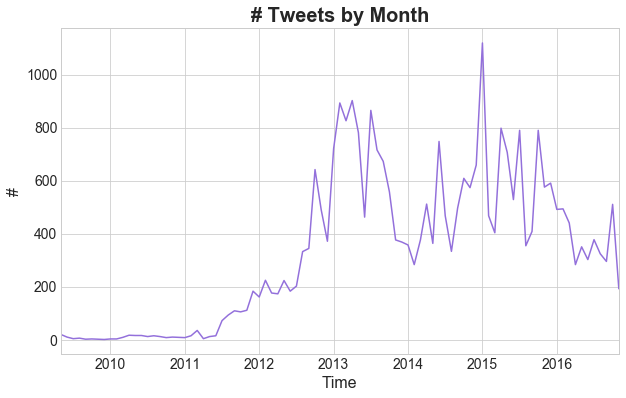

In [5]:
count_by_month = df[df['created_at'] < datetime(2016,12,1)].groupby('first_day_month_cohort').size()
count_by_month.plot(figsize=(10, 6), **plots_args);
plt.title('# Tweets by Month', fontsize=20, fontweight='bold'); 
plt.xlabel('Time', fontsize=16); plt.ylabel('#', fontsize=16);
plt.savefig(FIGURE_FOLDER + 'count_by_month.png')

We can observe a bump in Trump's Twitter activity around mid-2012. He annouced his campaign in middle of 2015 and there is no skip in the period.

### Missingness

In [6]:
def describe_missing(df):
    missing = []

    for c in df.columns:
        count_missing = pd.isnull(df[c]).sum()
        
        #only show columns with non-zero number of missing values
        if count_missing > 0:
            missing.append((c, round(count_missing*100 / df.shape[0], 2)))

    return pd.DataFrame(missing, columns=['col', '% missings']).set_index('col')

HTML(describe_missing(df).to_html())

,% missings
col,
place.country,90.84
place.name,90.84
geo.coordinates,92.64
coordinates.coordinates,92.64


Only the fields corresponding to location have missing values. One of our research questions is about geographic position, but seems like we won't be able to have a lot of accuracy and enough data to analyse. Let's [check](#Location) how `geo.coordinates` behaves over time. Moreover, since we are dealing with a single person's tweet, it may not be very insightful as the location of tweet may only be loosely related to its content.

### Device

This [blog post](http://varianceexplained.org/r/trump-tweets/) does a sentimental analysis of tweets split by device and it was found that certain types of devices tend to have more aggressive messages than others. Below we can see the number of tweets by device and quarter.

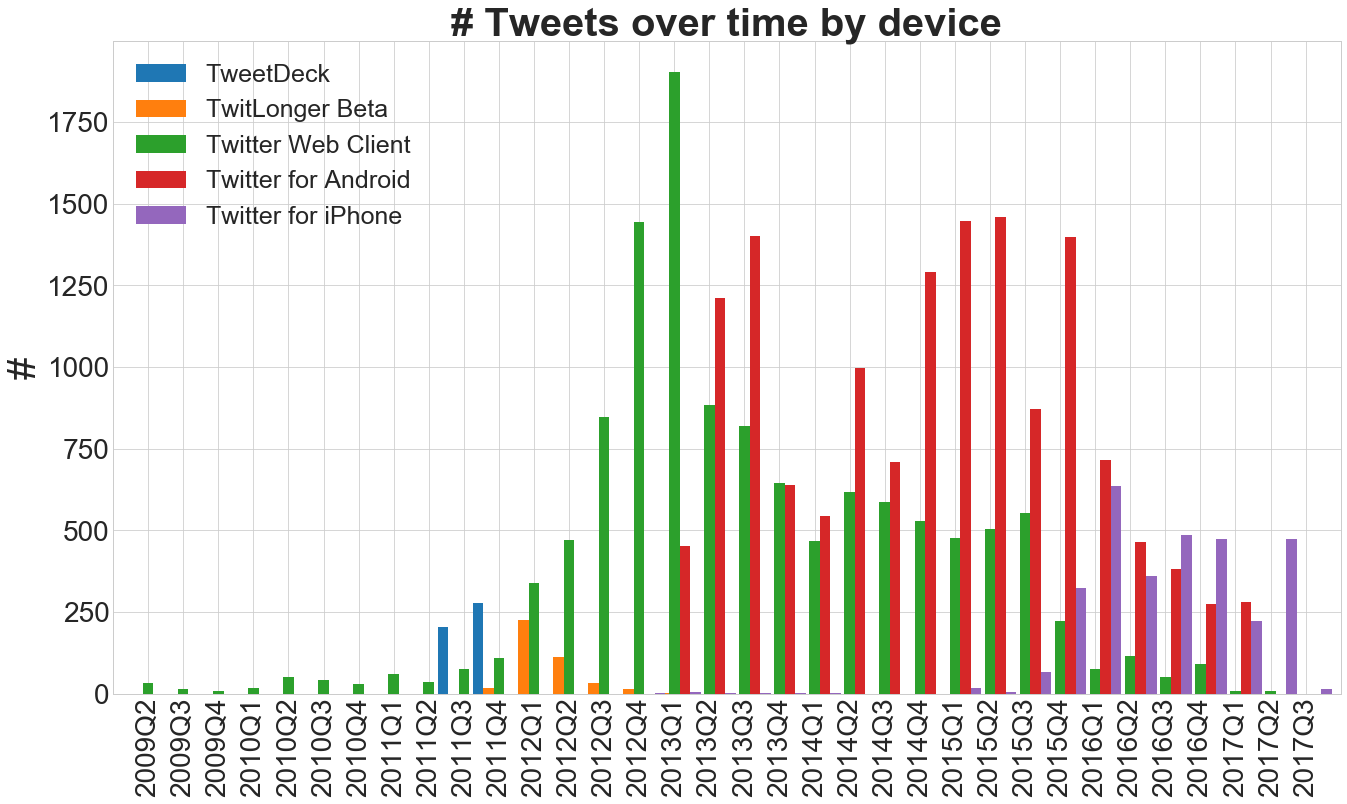

In [7]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:5].index)
devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
                     .groupby(['quarter_cohort', 'source'])
                     .size().unstack().fillna(0)
                     .plot(kind='bar', figsize=(22, 12), fontsize=28, width=1.5));
plt.title('# Tweets over time by device', fontsize=40, fontweight='bold'); 
plt.xlabel('', fontsize=40); 
plt.ylabel('#', fontsize=40);
plt.legend(fontsize=25)
plt.savefig(FIGURE_FOLDER + 'device_over_time.png')

From the chart above we can see that today Trump and his team uses mostly `iPhone` and `Android`. In the section [Clean and Analyse Text](#Clean-and-Analyse-Text) some analysis regarding the content of the tweet by device will be done.

### Weekday

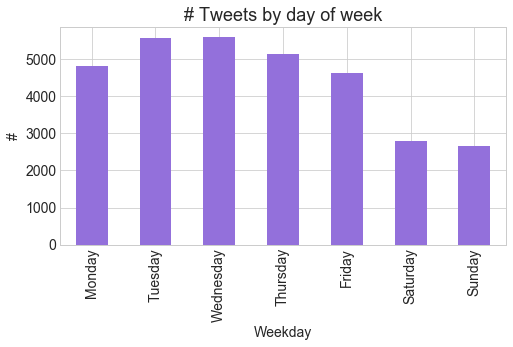

In [8]:
weekday = (pd.DataFrame(df.groupby(['weekday', 'weekday_number'])
                       .size()).reset_index()
           .sort_values('weekday_number')
           .set_index('weekday'))
del weekday['weekday_number'];
weekday.plot(kind='bar', figsize=(8, 4), legend=None, **plots_args);
plt.title('# Tweets by day of week', fontsize=18); 
plt.xlabel('Weekday', fontsize=14); plt.ylabel('#', fontsize=14);

As expected, the weekend is weaker than the others days but as we'll see in [Favorite](#Favorite) those are the best day to engage people.

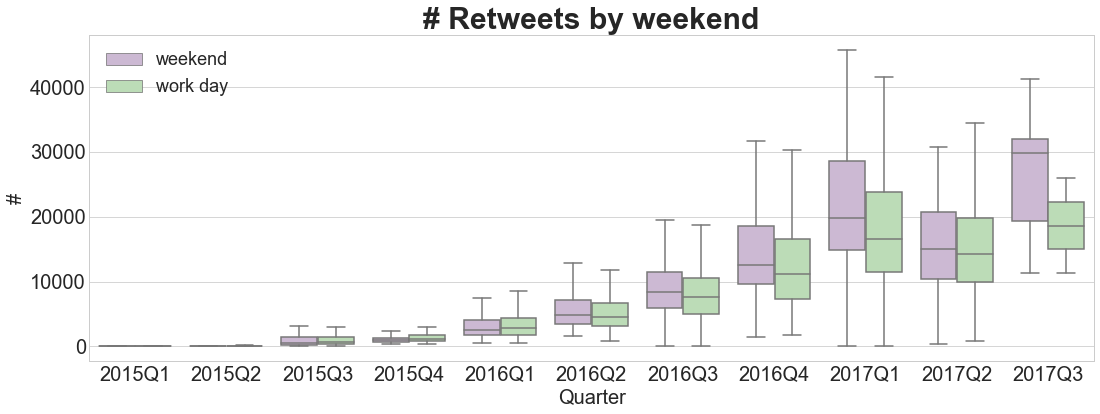

In [9]:
plt.figure(figsize=(18,6))
df['nice_weekend'] = df['is_weekend'].apply(lambda x: 'weekend' if x else 'work day')
sns.boxplot(x='quarter_cohort', y='retweet_count', hue='nice_weekend',
            data=df[df['first_day_month_cohort'] > datetime(2015,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.legend(fontsize=18)
plt.title('# Retweets by weekend', fontsize=30, fontweight='bold'); 
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.xlabel('Quarter', fontsize=20); plt.ylabel('#', fontsize=20);
plt.savefig('../history/figures/retweets_by_dayofweek.png')

### Location

In section [Missingness](#Missingness) the variable `geo.coordinates` has a lot of missing values, however they are well spreaded over time, so it is still worth doing the analysis of geo location

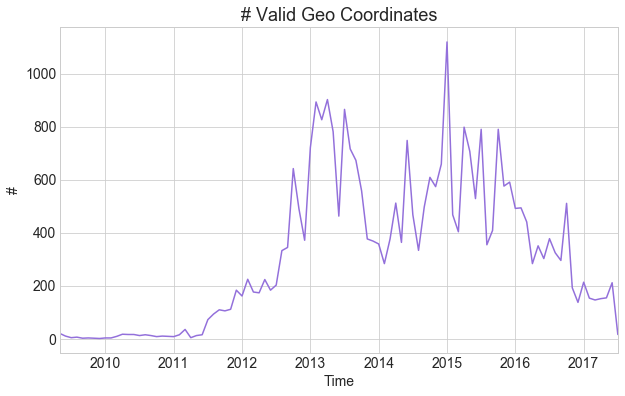

In [10]:
coord = df[['geo.coordinates', 'first_day_month_cohort']].copy()
coord['is_valid_coord'] = coord['geo.coordinates'].apply(lambda x: pd.notnull(str(x)))
coord_non_missing = coord.groupby('first_day_month_cohort').sum()

coord_non_missing.plot(figsize=(10, 6), legend=None, **plots_args);
plt.title('# Valid Geo Coordinates', fontsize=18); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=14);

In [11]:
valid_geo = df[pd.notnull(df['geo.coordinates'])][['geo.coordinates', 'month_cohort', 'text']].values
m = folium.Map()

for tweet in valid_geo:
    folium.RegularPolygonMarker(tweet[0], 
                            popup=tweet[1],
                            fill_color='#45647d',
                            number_of_sides=4,
                            radius=1).add_to(m)
m.save('figures/map_tweets.html')

> ### [Check Tweet's map](https://rawgit.com/liabifano/project/master/analysis/figures/map_tweets.html)

The field `place.country` is calculated has the following distribution however is not that usefull because most of them are in United States

In [13]:
HTML(pd.DataFrame(pd.Series(df.groupby('place.country').size()).sort_values(ascending=False)).to_html())

,0
place.country,
United States,2784
United Kingdom,34
India,13
Ireland,9
Italy,7
Russia,3
Republic of Croatia,3
,3
Kingdom of Saudi Arabia,2


### Favorite
Based on the [twitter's documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) the field `favorite_count` is defined as the approximated how many times the tweet has been liked by Twitter's users.

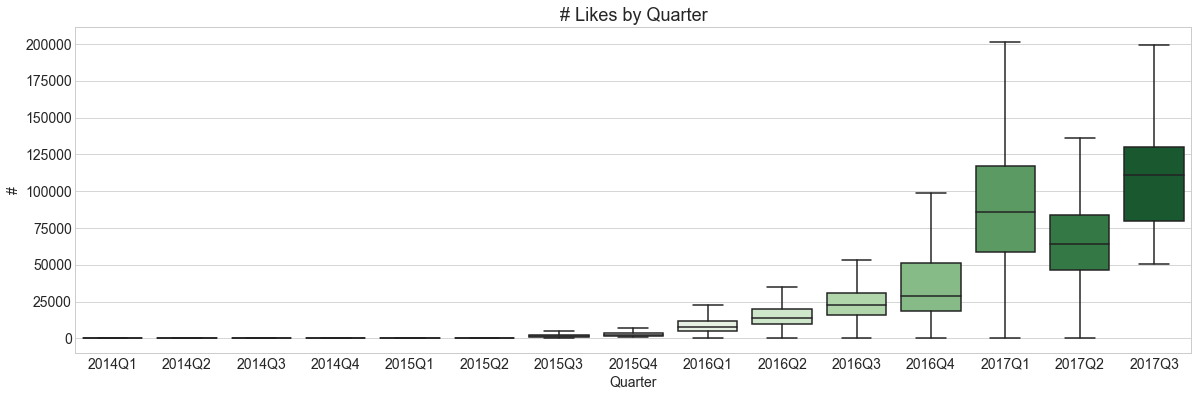

In [14]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='favorite_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Likes by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

Another hypotesis is if the tweets in the weekend have a better chances to be liked, because people are more available in the weekends

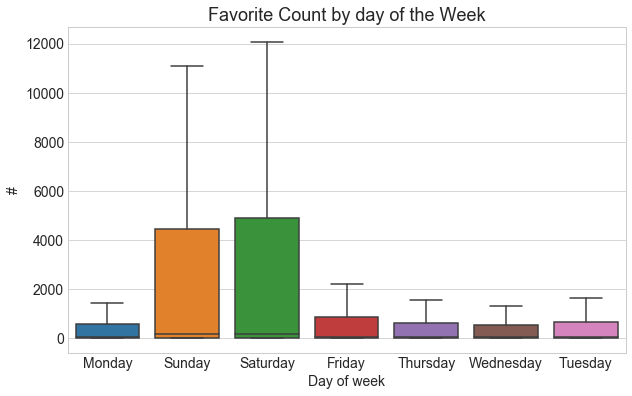

In [15]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='favorite_count', x='weekday', data=df, showfliers=False);
plt.title('Favorite Count by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

### Retweets

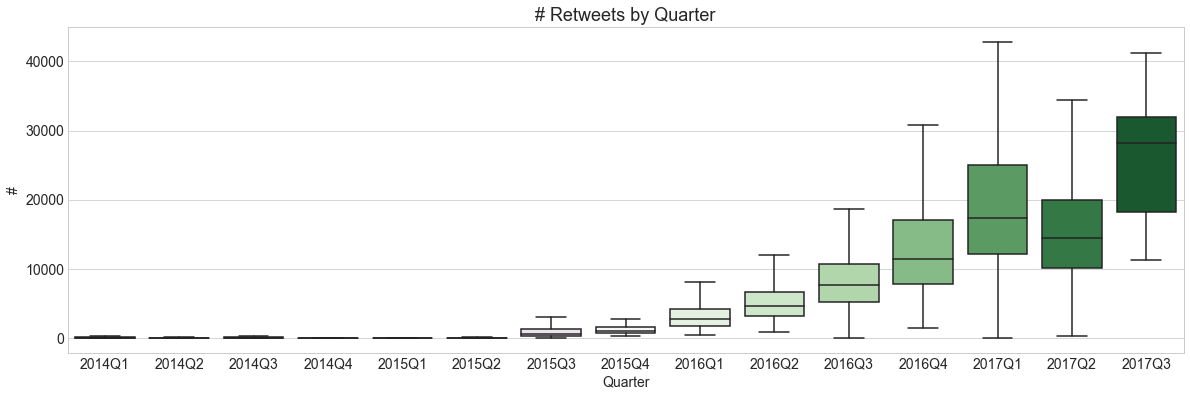

In [16]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='retweet_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Retweets by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

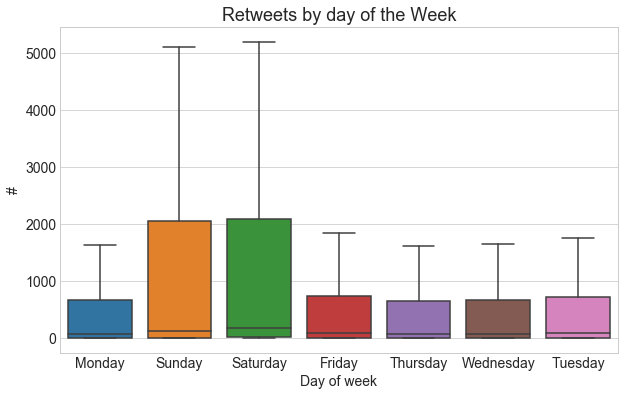

In [17]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='retweet_count', x='weekday', data=df, showfliers=False); # organize days
plt.title('Retweets by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

**It can be noted that the behavior of retweets is the same as that of the likes**.

### Followers

The distribution of number of followers is very stable until middle of 2016, in the middle of 2016 the elections starts and it can be seen a spike. Another spike can be seen in the end of 2016 when he won the elections.

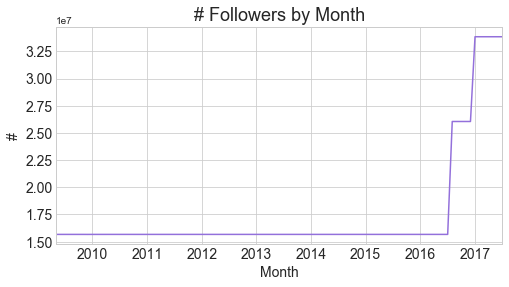

In [18]:
plt.figure(figsize=(8,4))
df.groupby('first_day_month_cohort').max()['user.followers_count'].plot(kind='line', **plots_args)
plt.title('# Followers by Month', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Month', fontsize=14); plt.ylabel('#', fontsize=14);

## Clean and Analyse Text
* Clean stop words from dataset.

In [19]:
df['preprocessed_text'] = text.preprocessing_text(df['text'])
df['clean_text'] = text.remove_stop_words(df['preprocessed_text'])

After remove stop words, let's see what are the words that appear in hist tweets.

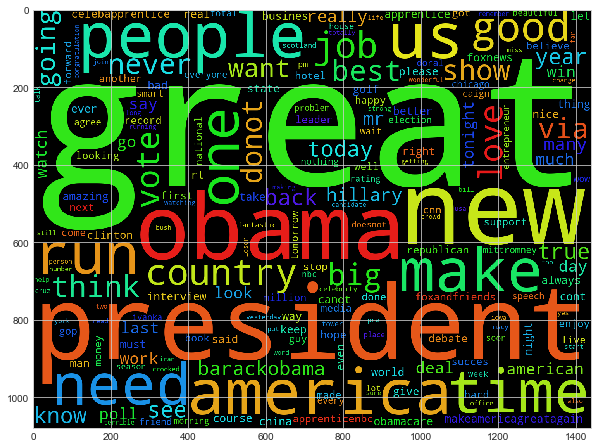

In [20]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
cloud = WordCloud(width=1440, height=1080).generate(' '.join(df['clean_text']));
ax.imshow(cloud);

Is this word count changing over time? Let's see how this is for every quarter.

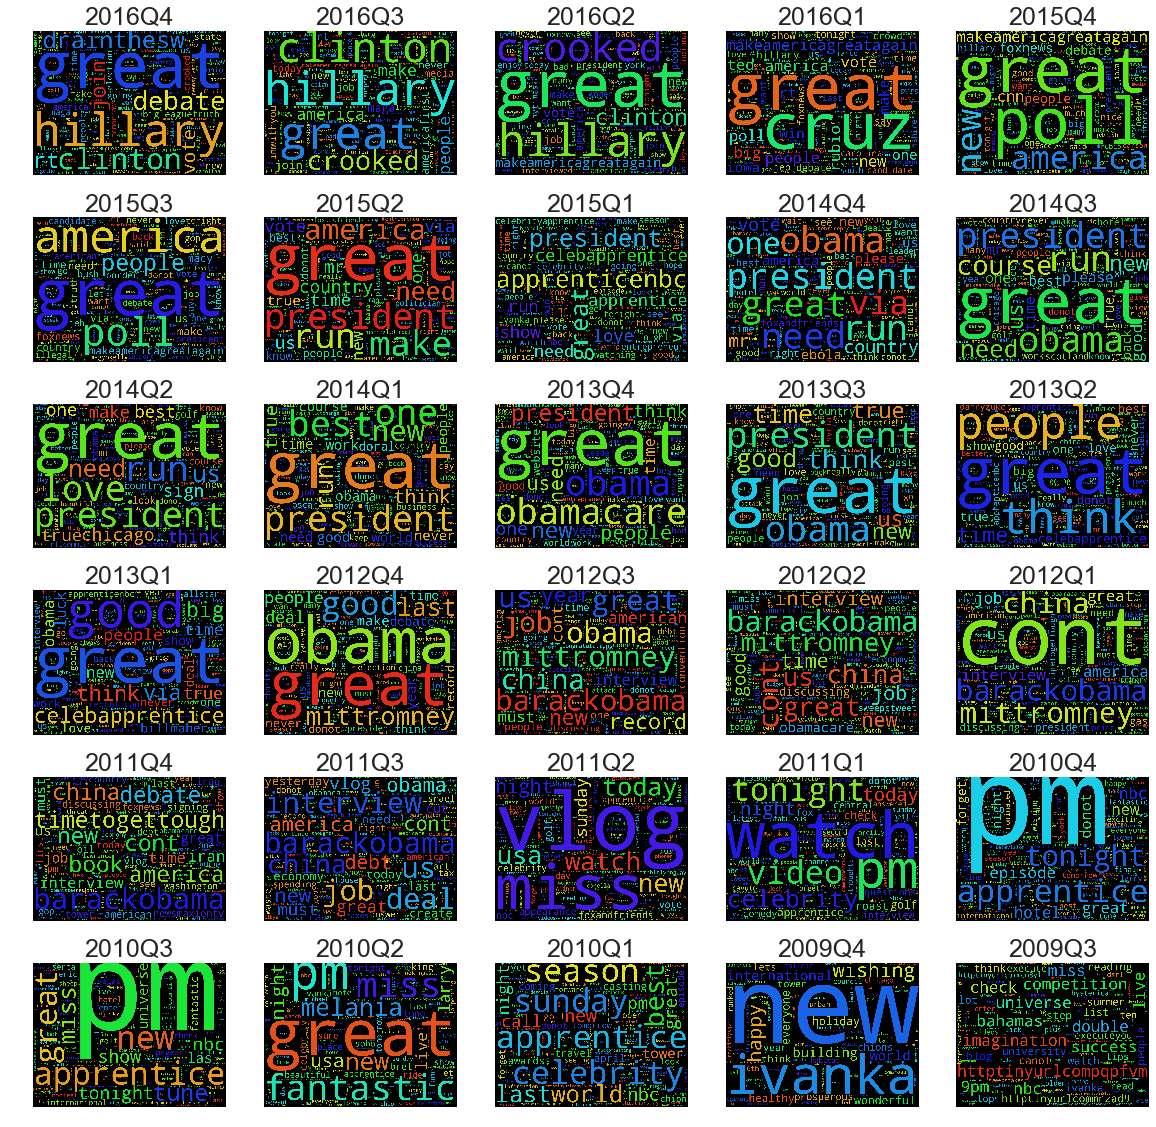

In [21]:
cohorts = df['quarter_cohort'].unique()[3:-1]

f, ax = plt.subplots(6, 5, figsize=(20, 20))
positions = np.array(range(30)).reshape(6, 5)
for num_c, c in enumerate(cohorts):
    pos = np.where(positions==num_c)
    
    tweets_cohort = df[df['quarter_cohort']==c]['clean_text']
    cloud = WordCloud(width=1440, height=1080).generate(' '.join(tweets_cohort));
    ax[pos[0][0], pos[1][0]].imshow(cloud);
    ax[pos[0][0], pos[1][0]].set_title('{c}'.format(c=c), fontsize=25)
    ax[pos[0][0], pos[1][0]].axis('off')
plt.savefig(FIGURE_FOLDER + 'word_cloud_by_semestre.png')

## Topics classification

* Check if LDA model is a feasible approach to find topics and then classify tweets.

In [2]:
def tweet_clean(texts):
    
    for tweet in texts:
        count = 0
        lis = []
        
        for word in tweet:
            condition = ('http' in word) or ('rt' == word) or ('www' in word) or ('w' == word) or ('cont' == word)
            if condition:
                lis.append(count)
            count = count + 1
    
        count = 0
        for l in lis:
            l = l - count
            del tweet[l]
            count = count + 1
    
    return texts

In [3]:
def corpus_creation(new_df, method):
    
    documents = list(new_df['clean_text'])
    
    stoplist = set(stopwords.words('english'))
    stoplist.add('amp')
    
    texts = [[word for word in document.lower().split() if word not in stoplist]for document in documents]
    
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    
    texts = tweet_clean(texts)
    
    if method != 'nmf':
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        return corpus, dictionary
    
    else:
        doc = " ".join(word for tweet in texts for word in tweet)
        doc = doc.split(" ")
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(doc)
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        return tfidf, tfidf_feature_names

In [4]:
def display_topics(model, feature_names, no_top_words):
    
    mod = []
    for topic_idx, topic in enumerate(model.components_):
        t = ()
        # print("Topic {}:".format(topic_idx))
        t = t + (topic_idx,)
        lis = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        # print(lis)
        t = t + (lis,)
        mod.append(t)
    return mod

In [5]:
def topic_modelling(start_date, end_date, method, original_df, num_topics, num_words):
    
    mask = (original_df['created_at'] > start_date) & (original_df['created_at'] <= end_date)
    new_df = original_df.loc[mask]
    
    if method != 'nmf':
        corpus, dictionary = corpus_creation(new_df, method)
    
    else:
        tfidf, tfidf_feature_names = corpus_creation(new_df, method)
        
    if method == 'lda':
        lda = LdaModel(corpus, id2word = dictionary, num_topics = num_topics)
        model = lda.print_topics(num_topics= num_topics, num_words = num_words)
    if method == 'hdp':
        hdp = HdpModel(corpus, id2word = dictionary)
        model = hdp.print_topics(num_topics = num_topics, num_words = num_words)
    if method == 'nmf':
        nmf = NMF(n_components = num_topics, alpha = 0.1, l1_ratio = 0.5, init = 'nndsvd').fit(tfidf)
        model = display_topics(nmf, tfidf_feature_names, num_words)
        
    return model

In [6]:
def create_wordle(model):
    
    wordle = []
    for i in range(len(model)):
        string = model[i][1]
        words = " ".join(re.findall("[a-zA-Z]+", string))
        wordle.extend(words.split())
    return wordle

In [27]:
def topic_viz(df, method, num_topics, num_words):
    
    cohorts = df['quarter_cohort'].unique()[0:-4]
    
    f, ax = plt.subplots(6, 5, figsize=(20, 20))
    positions = np.array(range(30)).reshape(6, 5)
    
    for i, quarter in tqdm(enumerate(cohorts)):
        
        pos = np.where(positions == i)
        
        start_date = quarter.start_time
        end_date = quarter.end_time
        
        model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
        
        wordle = create_wordle(model)
        
        freq = Counter(wordle)
        
        #mask = np.array(Image.open("trump.jpg"))
        cloud = WordCloud(width=1640, height=1280, max_words=100).fit_words(freq);
        
        ax[pos[0][0], pos[1][0]].imshow(cloud);
        ax[pos[0][0], pos[1][0]].set_title('Quarter: {}'.format(quarter))
        ax[pos[0][0], pos[1][0]].axis('off')

Now that we have all functions in order, let's have a look at some of the results.

Firstly, we'll try to look at the results of applying LDA on all the tweets.

In [43]:
start_date = '2009-05-01'
end_date = '2017-10-01'
method = 'lda'
num_topics = 8
num_words = 8

In [46]:
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.015*"new" + 0.014*"great" + 0.014*"interview" + 0.013*"pm" + 0.013*"book" '
  '+ 0.011*"via" + 0.010*"tonight" + 0.009*"2012"'),
 (1,
  '0.019*"president" + 0.019*"golf" + 0.016*"think" + 0.016*"run" + '
  '0.014*"happy" + 0.012*"like" + 0.011*"course" + 0.011*"would"'),
 (2,
  '0.017*"china" + 0.015*"us" + 0.015*"great" + 0.011*"interview" + '
  '0.009*"needs" + 0.009*"hope" + 0.009*"america" + 0.008*"doral"'),
 (3,
  '0.018*"obama" + 0.011*"oil" + 0.009*"true" + 0.009*"debt" + 0.008*"last" + '
  '0.008*"never" + 0.007*"money" + 0.007*"mittromney"'),
 (4,
  '0.065*"barackobama" + 0.011*"show" + 0.011*"one" + 0.010*"miss" + '
  '0.010*"apprentice" + 0.009*"night" + 0.009*"new" + 0.009*"great"'),
 (5,
  '0.018*"discussing" + 0.011*"art" + 0.009*"house" + 0.009*"ivanka" + '
  '0.009*"sure" + 0.008*"scotland" + 0.007*"beautiful" + 0.007*"video"'),
 (6,
  '0.015*"obama" + 0.014*"obamacare" + 0.011*"season" + 0.010*"must" + '
  '0.009*"iran" + 0.009*"get" + 0.009*"us" + 0.008*"chi

We obtain a list of 8 topics, described by 8 words each (as specified by the input parameters).

As we can see, there isn't much clarity on what those 8 words are trying to say about each topic. Also, pretty major topics like `fake news`, `hillary clinton`, `immigration` seem to be missing entirely. We believe that this might be happening due to the large time-scale that we are choosing. Let's try and narrow down our search window and judge whether we obtain something better.

Specifically, let's narrow down to the last three months before elections, the time when the competition between Hillary and Trump was at its peak.

In [47]:
start_date = '2016-08-08'
end_date = '2016-11-08'
method = 'lda'

In [48]:
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.021*"clinton" + 0.014*"join" + 0.014*"hillary" + 0.012*"imwithyou" + '
  '0.011*"poll" + 0.011*"iowa" + 0.010*"americafirst" + 0.009*"tomorrow"'),
 (1,
  '0.017*"great" + 0.016*"hillary" + 0.014*"maga" + 0.010*"people" + '
  '0.010*"drainthesw" + 0.010*"going" + 0.009*"clinton" + 0.009*"make"'),
 (2,
  '0.025*"clinton" + 0.018*"maga" + 0.014*"imwithyou" + 0.012*"hillary" + '
  '0.011*"debate" + 0.010*"makeamericagreatagain" + 0.009*"tonight" + '
  '0.009*"americafirst"'),
 (3,
  '0.018*"get" + 0.015*"great" + 0.013*"join" + 0.012*"makeamericagreatagain" '
  '+ 0.010*"america" + 0.010*"ohio" + 0.010*"live" + 0.009*"watch"'),
 (4,
  '0.032*"hillary" + 0.023*"great" + 0.015*"clinton" + 0.012*"crooked" + '
  '0.011*"debate" + 0.010*"make" + 0.009*"america" + 0.008*"last"'),
 (5,
  '0.020*"bigleaguetruth" + 0.013*"hillaryclinton" + 0.013*"great" + '
  '0.013*"hillary" + 0.012*"debate" + 0.012*"clinton" + 0.012*"team" + '
  '0.009*"join"'),
 (6,
  '0.016*"clinton" + 0.015*"crooked"

These set of topics seem to be much better than the last set. We can clearly observe Trump's focus on `debate night`, `crooked hillary` and `ohio elections`. This was indeed what was happening during those months.

So, as we thought, indeed it was the trouble with choosing the correct timeframe for topic modelling.

Let's try to see results with other methods for the same set of dates.

In [49]:
# Negative Matrix Factorization
method = 'nmf'
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0, 'hillary york foundation geneva gave gates future friends'),
 (1, 'clinton york foundations genflynn geneva gave gates future'),
 (2, 'great york foundation geneva gave gates future friends'),
 (3, 'join york foundation geneva gave gates future friends'),
 (4, 'maga york gets geneva gave gates future friends'),
 (5, 'america york foundations genflynn geneva gave gates future'),
 (6, 'drainthesw york foundations genflynn geneva gave gates future'),
 (7, 'debate york getting genflynn geneva gave gates future')]


Very less variance in topics, repetitive topic words, overall - not better than LDA.

In [50]:
# Hierarchical Dirichlet Process
method = 'hdp'
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.005*morning + 0.005*making + 0.005*oreillyfactor + 0.004*miami12pm + '
  '0.004*immigration + 0.004*without + 0.004*believe + 0.004*health'),
 (1,
  '0.005*attn + 0.005*praised + 0.005*need + 0.005*turn + 0.004*worst + '
  '0.004*obamacare + 0.004*jones + 0.004*available'),
 (2,
  '0.005*hook + 0.005*florida + 0.005*supported + 0.005*defeat + 0.004*use + '
  '0.004*wouldnot + 0.004*protects + 0.004*important'),
 (3,
  '0.006*vpdebate + 0.005*night + 0.005*take + 0.005*reset + 0.005*fail + '
  '0.005*delivered + 0.005*speech + 0.005*team'),
 (4,
  '0.006*reception + 0.005*mn + 0.005*mosul + 0.005*lose + 0.004*crowd + '
  '0.004*carolina + 0.004*enjoyed + 0.004*supported'),
 (5,
  '0.006*spent + 0.005*tune + 0.005*enforcement + 0.005*come + 0.005*staffers '
  '+ 0.005*appreciate + 0.005*show + 0.005*threat'),
 (6,
  '0.006*empowering + 0.005*graham + 0.004*participating + 0.004*instead + '
  '0.004*greeley + 0.004*turning + 0.004*stance + 0.004*ivanka'),
 (7,
  '0.008*close + 0

There's a higher variance of topics, topics are easily comprehensible from the generated topic words. Overall, seems better than LDA.

Now let's try to visualize topics on a quarterly basis, starting from 2010Q2. WordCLoud Viz is used for each quarter, using all the topic words obtained for each quarter.

30it [02:27,  4.90s/it]


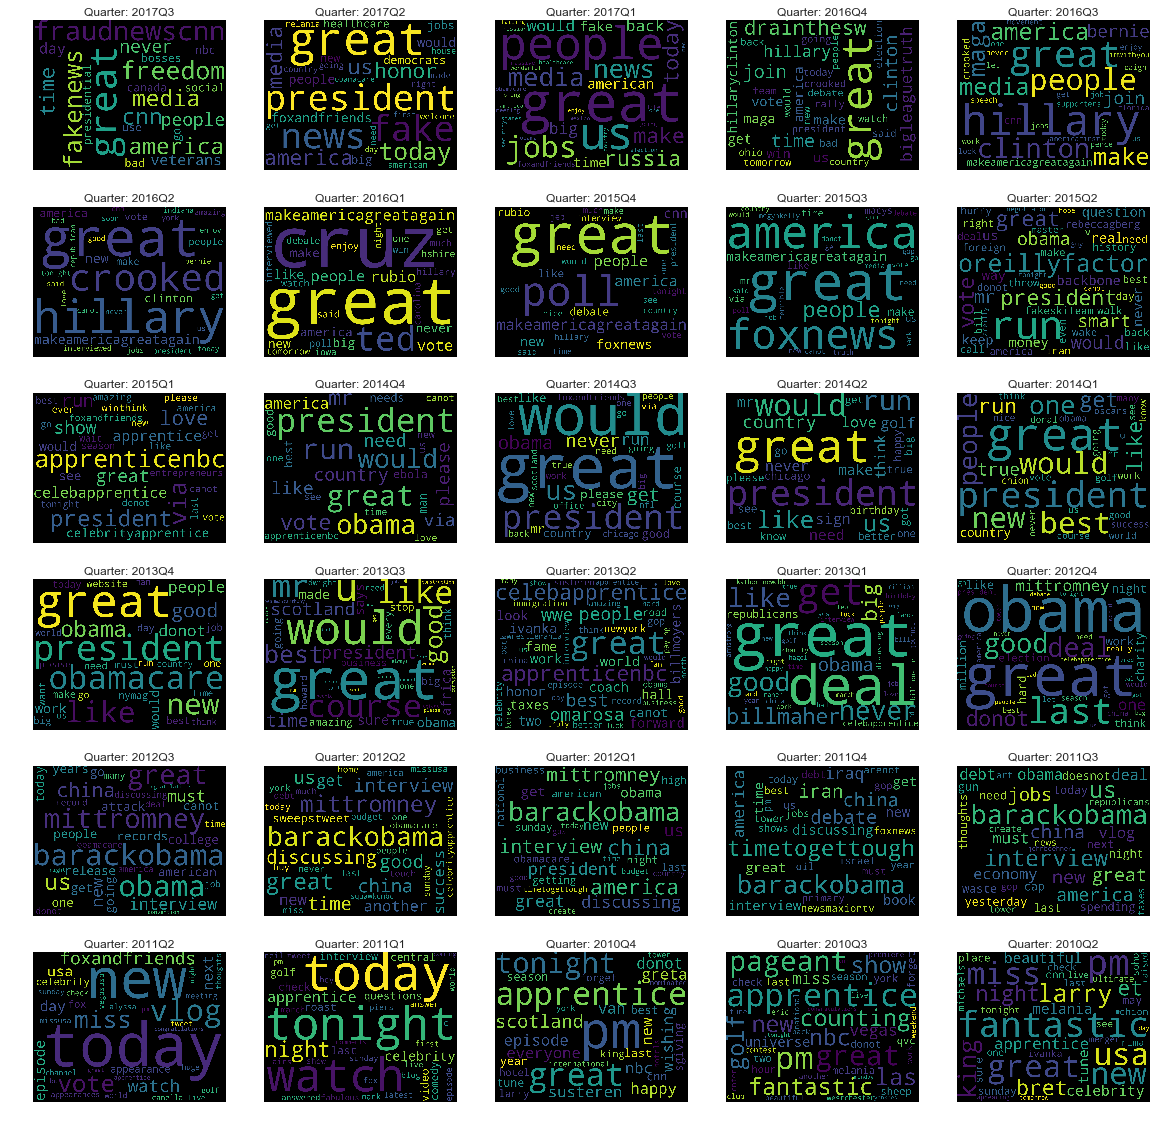

In [51]:
method = 'lda'
topic_viz(df, method, num_topics, num_words)

## Research Questions

* Have a final proposal of the topics that will be analysed to answer the `Research Questions`

### How linguistic tones create an impact?

* Sentiment Analysis - breaking down tweets into positive, neutral and negative remarks to figure out how Trump uses language to create an impact. This might also extend to recording the use of exclamation marks and capitalised words to measure the unambiguity of the tweet emotion.
* Ego Analysis - finding occurences involving the use of self to promote an idea/situation. This might give us important insights about the impact of his tweets.

Sentiments analysis will be performed using a pre-defined model.

Impact may be measured by measuring the increase in followers and/or counting the number of retweets and likes for each kind of sentiment expressed in the tweet.

We may not be going ahead with the particular idea - "recording the use of exclamation marks and capitalised words to measure the unambiguity of the tweet emotion" because we will be cleaning most of the data so that we get better results in sentiment analysis and topic modelling.

We may also not go ahead with this particular idea - "finding occurences involving the use of self to promote an idea/situation" because of similar reasons.

### Is it okay to generalize the sentiments based on ALL the tweets?

* Source Anaylsis - almost all major political players have an additional media team who handle their Twitter Account. Same can be said about Trump. We can analyze the metadata to find out if the tweet has been sent out by the media team or Trump himself. For example, we can have a look at the source of the tweet. (sent by iPhone/Android). This can help us in analyzing the tweets in a better way.

We will perform sentiment analysis and topic modelling on both cluster of tweets (ones obtained by iPhone and ones obtained by Android). We hope to get significantly different results for both clusters. Further analysis may nvolve filtering down the data based on one particular source.

Further follow-up maybe analyzing the number of retweets, likes - maybe a measure of how `sensational` the tweet is. Hypothesis - most likely to come from Android.

### Is it all about the timing?

* Temporal Analysis - this involves a broad spectrum of topics, ranging from analyzing Trump's favorite time of the day to tweet vs its impact to how his number of followers get affected as an aftermath of a sensational tweet and in general, analyzing the changing preference of voters through time.

Most of the analysis will involve uncovering the time patterns hidden behind the tweet data. This will give us insights as to when Trump is highly active, what is the popularity index of the tweet according to post time and whether there has been a change in tweet time trend before, during and after the campaign.

Define `sensational`, measure the corrleation between retweets and tweet timings.

We will not be going ahead with this particular idea - "analyzing the changing preference of voters through time" because our dataset involves only Trump's tweets only, so it isn't possible to gauge voter preferences.

### What are the distinct themes across tweets?

* Clustering Analysis - the tweets will be split into clusters based on its main topic. The cluster might be extracted by a heuristic logic based on a descriptive analysis of tweets or by Latent Dirichlet allocation (LDA) if it is feasible. We can then perform aforementioned temporal analysis for each topic.

As seen in the cells above, topic modelling pipeline using LDA indeed gives favorable results.

Other techniques like Hierarchical Dirichlet Process (HDP) and Negative Matrix Factorization (NMF) have also been explored in this Notebook, out of which HDP seems promising.

Another possible approach is to mine the topics from new sources to fetch topics/keywords relevant to US politics and related campaigns during the year of campaigning and elections.

We will be choosing upto 10 dominant clusters from the topic modelling pipeline and then proceed to assign topic to each of the tweets. Sentiment and Temporal Analysis into each of the following clusters are likely to reveal more insights into Trump's preferred topics and overall impacts of those topics.

As seen earlier, there is a significantly huge amount of missing geo-coordinate data (93 % missing). Hence, we will not be going ahead with this analysis.

## Data Story and Final Presentation

We will be presenting the results in the form of a data story.


## Next Steps
For the next step of this project the following analysis will be done:

#### Sentimental Analysis
- Among the datasets with sentimental score, we decided to move on with [
NRC Word-Emotion Association Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) dataset because it has a lot of different categories that can be transformed into positive and negative emotions like [David Robinson](http://varianceexplained.org/r/trump-tweets/) did in his blog post.
- After have the relative count of emotions by tweet we'll analyse the distribution of number of retweets and followers.


#### Topics inference
- Extract the morphological meaning of each word using [nltk](http://www.nltk.org/) library and try again run `LDA` model to infer topics. And if we are successful to get meanful topics, we'll count by time to see if the distribution changes over time.
- This [post](https://www.tensorflow.org/tutorials/word2vec) shows how to `word2vec` and `t-SNE` to visualize words that appears together. We will apply the same analysis in our dataset.

In [1]:
import sys
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime
import calmap

from trump import load, treat, text

from gensim.models.word2vec import Word2Vec 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from vaderSentiment import vaderSentiment

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from PIL import Image
from tqdm import tqdm
from pprint import pprint
from wordcloud import WordCloud 

plots_args = {'fontsize': 14, 'color': '#9370DB'}
FIGURE_FOLDER = '../history/figures/'

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/atul/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/atul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/atul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = load.load_tweets()

check function [load_tweets](https://github.com/liabifano/project/blob/master/trump/src/trump/load.py)

In [4]:
df['clean_tokens'], df['clean_text'] = text.clean_series(df['text'])

check function [clean_series](https://github.com/liabifano/project/blob/master/trump/src/trump/text.py)

# Writing Style

The manner of expressing thoughts is characteristic of a person that can change over time and also with the available resources to pass the message.

## Over time

### by punctuations and emojis

In [5]:
def plot_interval_by_cohort(df, cohort, metric, color):
    agg = (df
           .sort_values('first_day_month_cohort')
           .groupby(cohort)
           .describe()[metric])
    
    agg['lower_bound'] = agg['mean'] - 2*agg['std'] / np.sqrt(agg['count'])
    agg['upper_bound'] = agg['mean'] + 2*agg['std'] / np.sqrt(agg['count'])
    
    agg['lower_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['upper_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['mean'].plot(linestyle='-', linewidth=3, fontsize=20, color=c, legend=True);
    
    plt.title('Writing style by Quarter'.format(metric), fontsize=20); 
    plt.xlabel('Time', fontsize=20); plt.ylabel('Mean', fontsize=20);

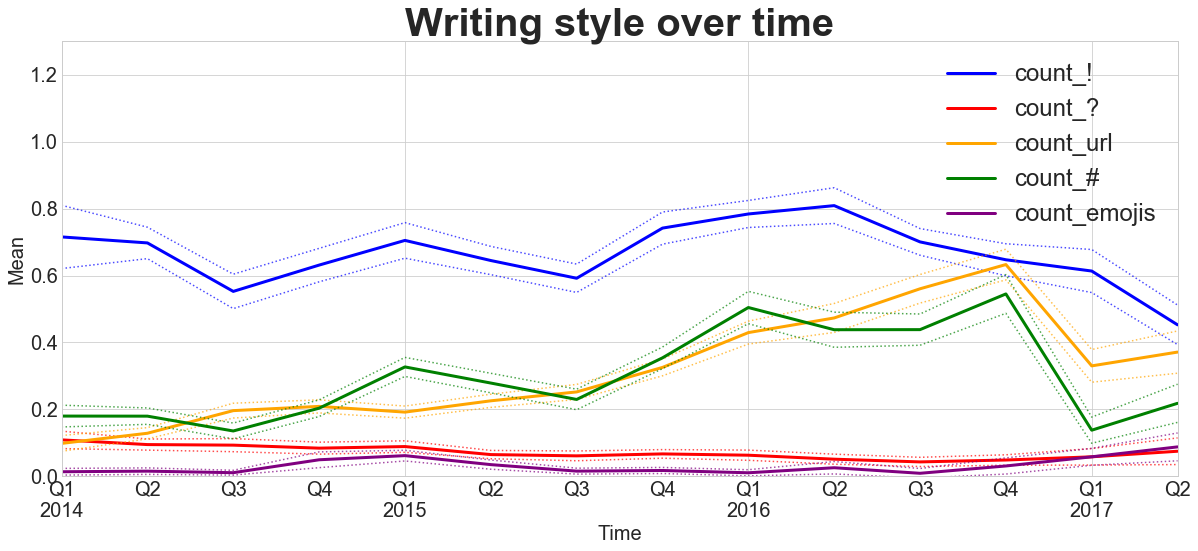

In [6]:
metric_writing_style = [('count_!', 'blue'),
                        ('count_?', 'red'), 
                        ('count_url', 'orange'),
                        ('count_#', 'green'),
                        ('count_emojis', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,8))
for m, c in metric_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1.3])
    plt.plot()
plt.legend(list(map(lambda x: x[0], metric_writing_style)), loc=1, fontsize=24);
plt.title('Writing style over time', fontsize=40, fontweight='bold'); 
plt.savefig(FIGURE_FOLDER + 'writing_style_over_time.png')

The only observation that can be seen from this chart is that the number of tweets containing urls is almost equal to the number of tweets containing the hashtag(#), which might be indictive of  the amount of retweets since urls and hashtags go hand in hand in such cases.

### by grammatical tags

In [7]:
tags = text.count_tags(df['clean_tokens'])
df = pd.concat([df, tags], axis=1)

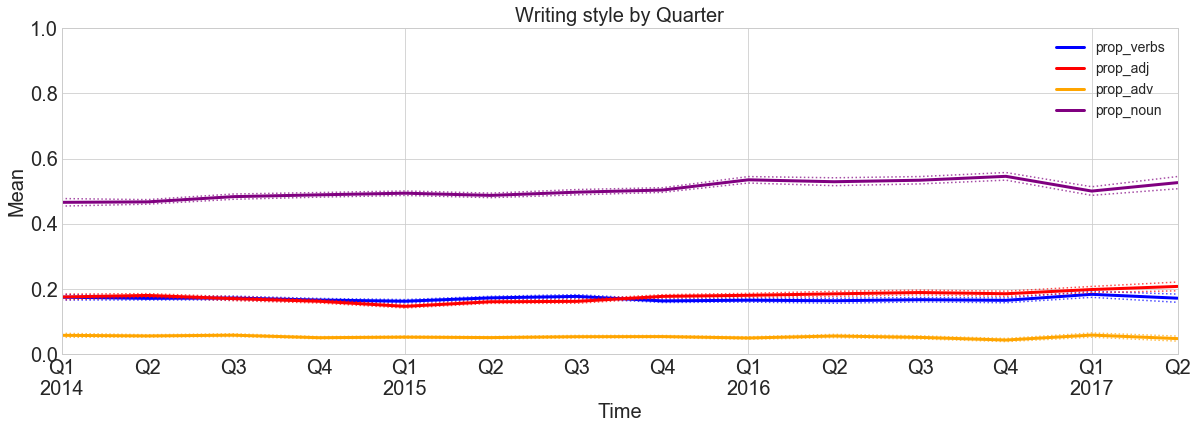

In [8]:
tags_writing_style = [('prop_verbs', 'blue'), 
                      ('prop_adj', 'red'),
                      ('prop_adv', 'orange'), 
                      ('prop_noun', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,6))
for m, c in tags_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1])
    plt.plot()
plt.legend(list(map(lambda x: x[0], tags_writing_style)), loc=1, fontsize=14);

As expected, we can see that Trump's writing behaviour is highly regular as it contains a relatively larger number of nouns, followed by verbs and adverbs.

### by subject

In [9]:
df = text.get_hardcoded_subjects(df)
subjects = ['hillary', 'obama', 'make_america', 'war', 'democra']

Number of tweets with hillary: 987 (3.2 %)


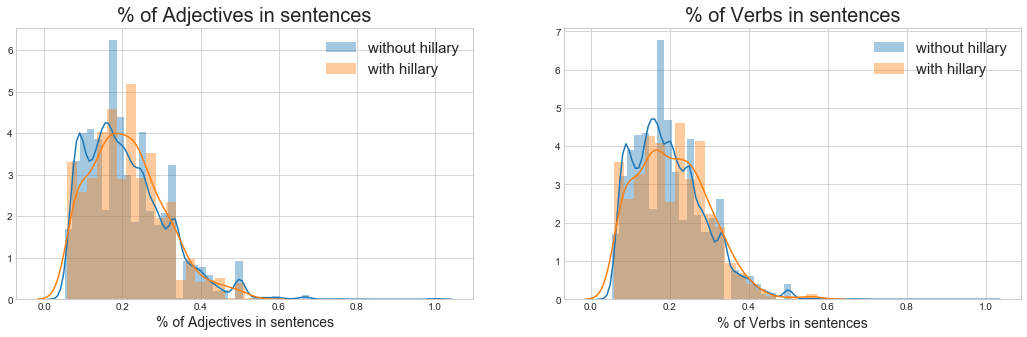

Number of tweets with obama: 2540 (8.1 %)


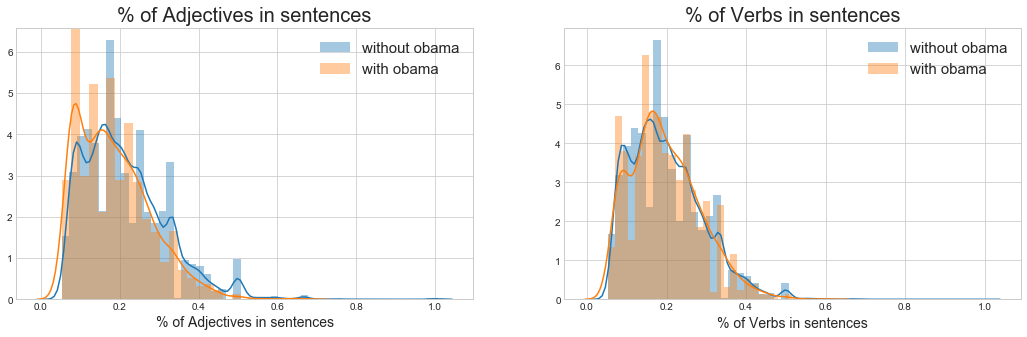

Number of tweets with make_america: 1070 (3.4 %)


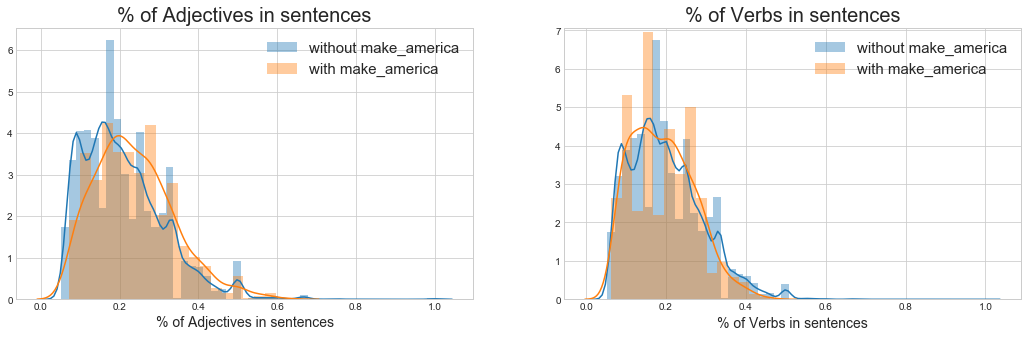

Number of tweets with war: 1165 (3.7 %)


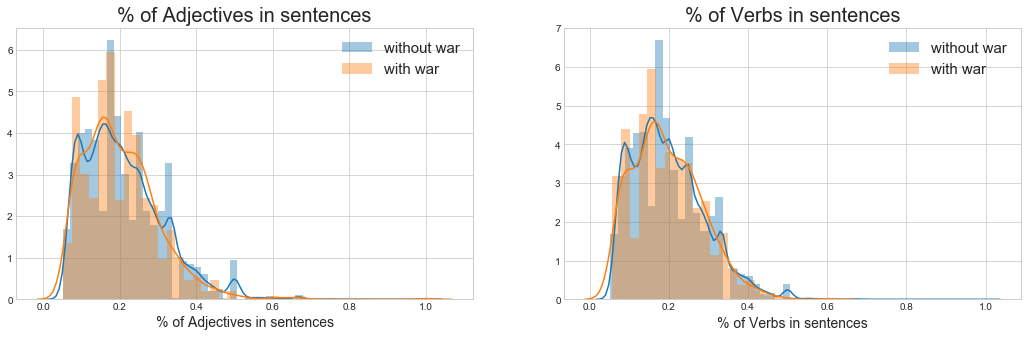

Number of tweets with democra: 218 (0.7 %)


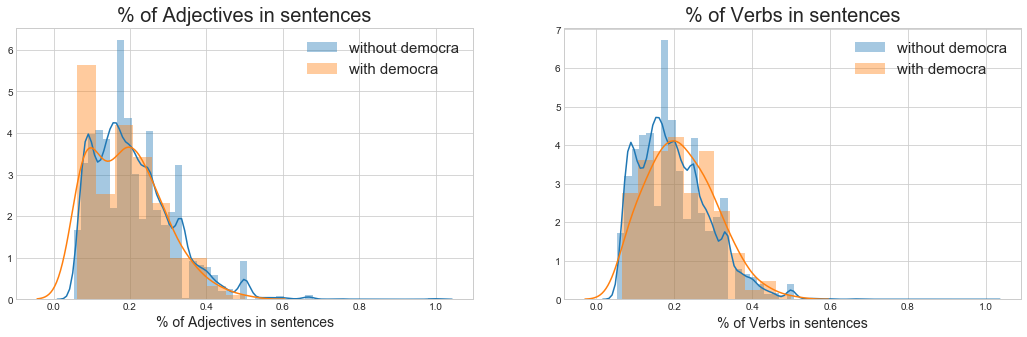

In [10]:
for sub in subjects:
    print('Number of tweets with {}: {} ({} %)'
          .format(sub, df[sub].sum(), 
                  round(100*df[sub].sum()/len(df), 1)))

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    filtered = df[df['prop_adj'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_adj'], ax=ax[0]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_adj'], ax=ax[0]);
    ax[0].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);
    ax[0].set_xlabel("% of Adjectives in sentences", fontsize=14)
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);

    filtered = df[df['prop_verbs'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_verbs'], ax=ax[1]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_verbs'], ax=ax[1]);
    ax[1].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[1].set_xlabel("% of Verbs in sentences", fontsize=14)
    ax[1].set_title('% of Verbs in sentences', fontsize=20);
    
    plt.show()

We can see that individual subject matters don't differ significantly in their grammatical styles, since the distributions are almost similar in each case.

### by Device

We first identify the valid devices as 'Twitter for iPhone', 'Twitter Web Client' and 'Twitter for Android'. Combining the tweet data from all these devices, we try to identify the features which are most important for differentiating between devices.

Out-of-bag score: 69.8%


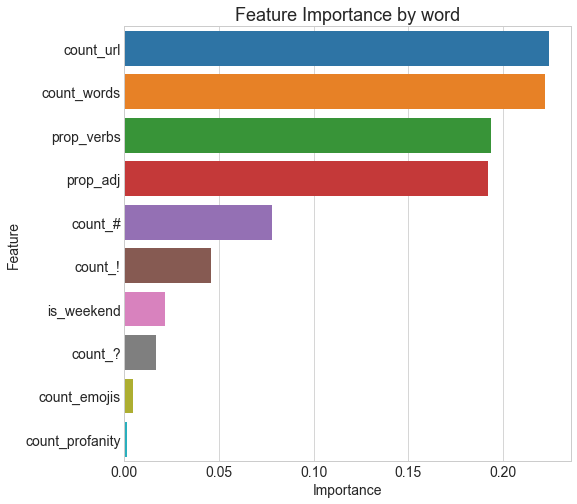

In [11]:
from sklearn.ensemble import RandomForestClassifier

valid_devices = ['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android']
features = ['is_weekend', 'count_url','count_!', 'count_?', 'count_#', 
            'count_words', 'count_emojis', 'count_profanity', 'prop_adj', 
            'prop_verbs']
df_channels = df[(df['source'].apply(lambda x: x in valid_devices)) & 
                 (df['first_day_month_cohort'] > datetime(2016,1,1)) & 
                 (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

def plot_importance_rf(df, features, label):
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=189, 
                                 oob_score=True)
    clf.fit(df[features], df[label]);

    importances = clf.feature_importances_
    feat_importance = (pd.DataFrame(list(zip(features, importances)), 
                               columns=['feature', 'importance'])
                  .sort_values('importance', ascending=False))
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y='feature', x='importance', 
                     data=feat_importance,
                     saturation=0.8)
    ax.set_title('Feature Importance by word', fontsize=18)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Importance', fontsize=14); plt.ylabel('Feature', fontsize=14);
    print('Out-of-bag score: {s}%'.format(s=100*round(clf.oob_score_, 3)));
    ax;
    
plot_importance_rf(df_channels, features, 'source')

We see that the count of urls, words, verbs, etc. (in order of importance) can help in differentiating between different devices.

In [40]:
df_channels['source'].unique()

array(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client'], dtype=object)

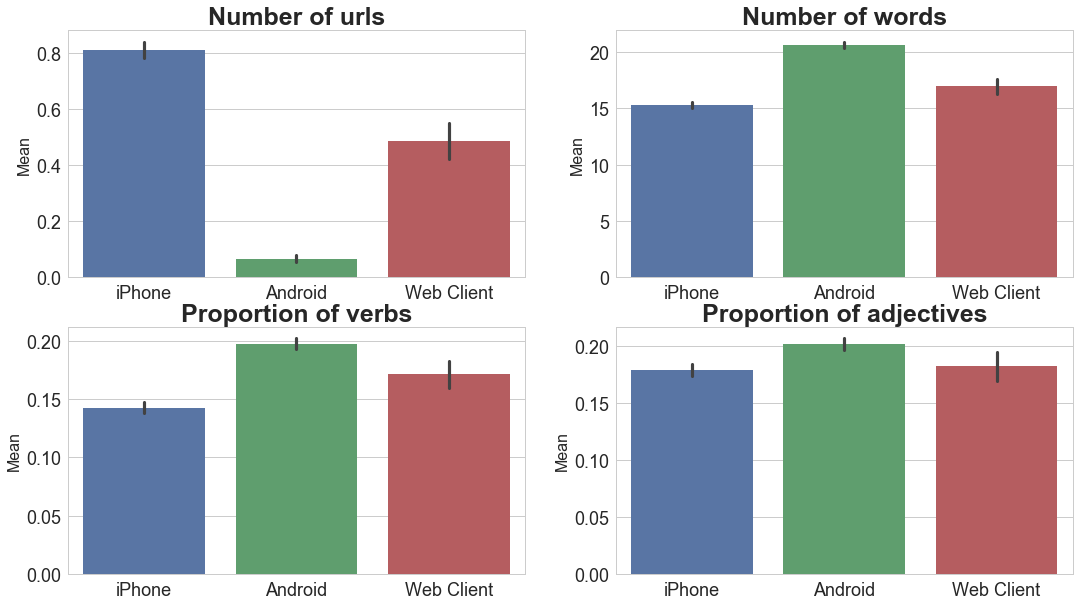

In [42]:
relevant_features = ['count_url', 'count_words', 'prop_verbs', 'prop_adj']
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
nice_lookup = {
    'count_url': 'Number of urls',
    'count_words': 'Number of words',
    'prop_verbs': 'Proportion of verbs',
    'prop_adj': 'Proportion of adjectives'
}
nice_sources = {
    'Twitter for iPhone': 'iPhone',
    'Twitter for Android': 'Android',
    'Twitter Web Client': 'Web Client'
}

df_channels['nice_source'] = df_channels['source'].apply(lambda x: nice_sources[x])
f, ax = plt.subplots(2, 2, figsize=(18, 10))
positions = np.array(range(4)).reshape(2, 2)

for i, feat in enumerate(relevant_features): 
    pos = np.where(positions==i)
    sns.barplot(x='nice_source', y=feat, data=df_channels, ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title(nice_lookup[feat], fontweight='bold', fontsize=25)
    ax[pos[0][0], pos[1][0]].set_xlabel('')
    ax[pos[0][0], pos[1][0]].set_ylabel('Mean', fontsize=16)
plt.savefig(FIGURE_FOLDER + 'writing_style_by_device.png')

When we look at the writing style split by devices, it shows huge styling differences. The chart below show metrics such as number of {urls, words, verbs, adjectives}. In android device, there are almost no urls, but the number of words and verbs are slightly higher than for other channels.

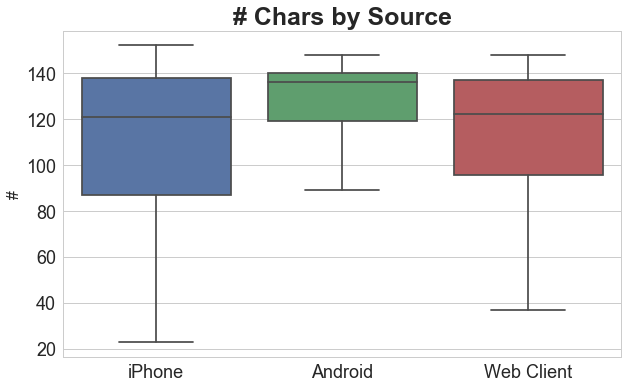

In [43]:
df['n_chars'] = df['text'].apply(len)
valid_devices = ['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android']
df_channels = df[(df['source'].apply(lambda x: x in valid_devices)) & 
                 (df['first_day_month_cohort'] > datetime(2016,1,1)) & 
                 (df['first_day_month_cohort'] < datetime(2017, 5, 30))]
df_channels['nice_source'] = df_channels['source'].apply(lambda x: nice_sources[x])

f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(y='n_chars', x='nice_source', data=df_channels, showfliers=False);
ax.set_title('# Chars by Source', fontweight='bold', fontsize=25);
ax.set_xlabel('');
ax.set_ylabel('#', fontsize=16);
plt.savefig(FIGURE_FOLDER + 'chars_by_device.png')

We observe that the number of characters in tweets from Android is relatively higher. This suggests that Trump (because he is known to use Android) prefers tweeting longer tweets in comparison to his supporting team.

# Word2Vec

Word2vec is a method to predict the co-occurence matrix of words in a document, that means that it is able to capture the context of two words appears. After run word2vec it is possible to calculate the cosine similarity of two words and find which words are closer to each other.

In [12]:
tweet_w2v = Word2Vec(size=100, min_count=1)
tweet_w2v.build_vocab([x for x in list(list(df['clean_tokens']))])
tweet_w2v.train([x for x in list(df['clean_tokens'])], 
                epochs=tweet_w2v.iter,
                total_examples=tweet_w2v.corpus_count)
word_vectors = tweet_w2v.wv
print('Number of words: {}'.format(len(word_vectors.vocab)))

Number of words: 43258


In [13]:
context_words = ['america', 'democrats', 'republicans',
                 'hillary', 'obama', 
                 'war', 
                 'russia', 'china', 'iran', 'syria', 'brazil', 'mexico',
                 'cnn', 'fake', 'crooked']

contexts = pd.DataFrame()
for w in context_words:
    context = pd.DataFrame([x[0] for x in word_vectors.most_similar(w)], columns=[w])
    contexts = pd.concat([contexts, context], axis=1)
contexts

,america,democrats,republicans,hillary,obama,war,russia,china,iran,syria,brazil,mexico,cnn,fake,crooked
0,collapsing,americans,syria,hilary,unfit,party,rigged,barackobama,trade,americans,whole,sell,watching,hit,beat
1,america…,candidate,democrats,crooked,china,takes,isis,stop,u.s.,democrats,firm,enemy,hours,short,clinton
2,periscopeco,syria,stop,beat,'16,system,destroy,jail,republicans,stop,considered,control,mornings,different,bernie
3,country,stop,u.s.,obama,vladimir,crime,barack,republicans,iraq,republicans,goes,expect,network,yankees,judgement
4,together,republicans,iraq,choked,appoint,advantage,wrong,steal,incompetent,candidate,nfl,social,two,interested,barack
5,safe,dont,iran,boehner,opposes,bills,pay,russia,countries,actually,name,risk,morning_joe,talented,primaries
6,founding,actually,americans,clinton,choked,hillaryclinton,jail,iraq,syria,steal,test,chinese,starting,simply,bush
7,honorable,anyone,incompetent,happier,stupidly,send,fact,wants,seems,incompetent,1st,government,pageant,john,boehner
8,amercia,somebody,steal,judgement,endorse,voters,iraq,endorse,laughing,put,saved,plan,loyal,liked,jeb
9,negotiator,nothing,actually,even,boehner,expect,mitt,iran,senators,politicians,changed,rights,clock,con,handed


In [14]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 1.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.015375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.908348
[t-SNE] Error after 1000 iterations: 1.215198


# Sentimental Analysis

Humans are "generally" sentimental and emotional beings. Analysing the sentiment of someone's tweets' could tell us a great deal about the general thought process of the person. Here, we will present an in-depth analysis of the sentiments expressed by Trump on Twitter.

In [44]:
def return_sentiment(x):
    if x <= -0.25:
        return 'Negative'
    elif x >= 0.5:
        return 'Positive'
    else :
        return 'Neutral'

In [45]:
analyzer = vaderSentiment.SentimentIntensityAnalyzer()
df['sentiment_raw_score'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_raw_score'].apply(lambda x: return_sentiment(x))

In [48]:
pd.options.display.max_colwidth = 140
HTML(df.iloc[25:30][['text', 'sentiment', 'sentiment_raw_score']].to_html())

,text,sentiment,sentiment_raw_score
1312,"When it comes to the future of America’s energy needs, we will FIND IT, we will DREAM IT, and we will BUILD IT.… https://t.co/m0HmPbUZ6C",Positive,0.5904
1313,Statement on House Passage of Kate’s Law and No Sanctuary for Criminals Act. https://t.co/uPRy9XgK5A,Negative,-0.7096
1314,Good news out of the House with the passing of 'No Sanctuary for Criminals Act.' Hopefully Senate will follow.,Neutral,-0.0772
1315,"Good news, House just passed #KatesLaw. Hopefully Senate will follow.",Positive,0.6808
1316,"""Mattis Says Trump’s Warning Stopped Chemical Weapons Attack In Syria"" https://t.co/XL9LLNKh8i",Negative,-0.8519


Let us look at the distribution of the number of tweets classified based on the sentiments expressed in them. The raw sentiment scores lie between -1 and 1, with -1 denoting the most negative sentiment and vice versa

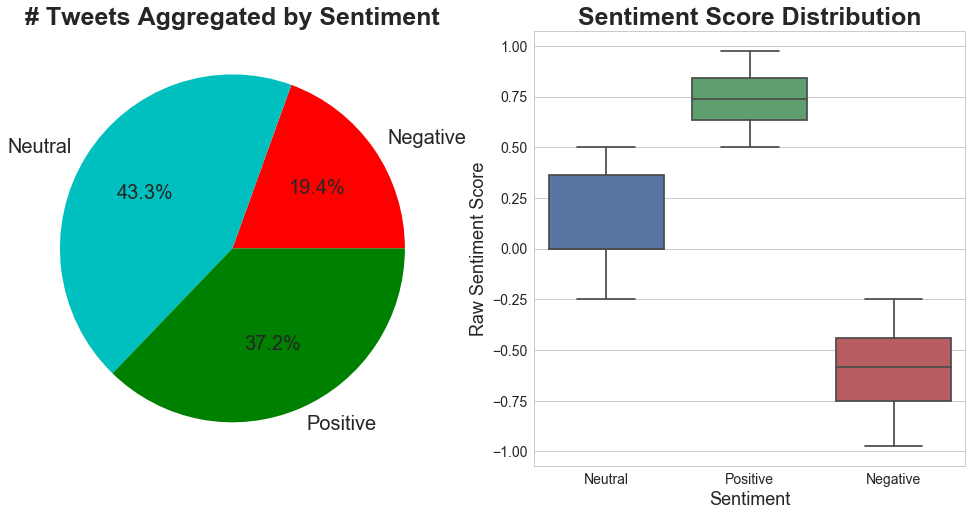

In [49]:
fig = plt.figure()
ax = fig.add_subplot(121)
count_by_sentiment = df[df['created_at'].apply(lambda x: x.year >= 2015)].groupby(['sentiment']).size()
count_by_sentiment.plot(figsize=(17, 8), kind='pie', autopct='%1.1f%%', fontsize=20, colors=['r', 'c', 'g']);
plt.title('# Tweets Aggregated by Sentiment', fontweight='bold', fontsize=25); 
#plt.xlabel('Sentiment', fontsize=14); 
plt.ylabel('', fontsize=18);


ax = fig.add_subplot(122)
ax = (sns.boxplot(y='sentiment_raw_score', 
                  x='sentiment', data=df[df['created_at']
                                         .apply(lambda x: x.year >= 2015)], showfliers=False));
#sx = sns.distplot(df[df['created_at'].apply(lambda x: x.year >= 2015)]['sentiment_raw_score'])
plt.title('Sentiment Score Distribution', fontweight='bold', fontsize=25);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Sentiment', fontsize=18); plt.ylabel('Raw Sentiment Score', fontsize=18);

plt.savefig(FIGURE_FOLDER + 'sentiment_counts.png')
#boxplot

It would also be interesting to see the temporal pattern in the distribution of the number of tweets based on the sentiment expressed in them.

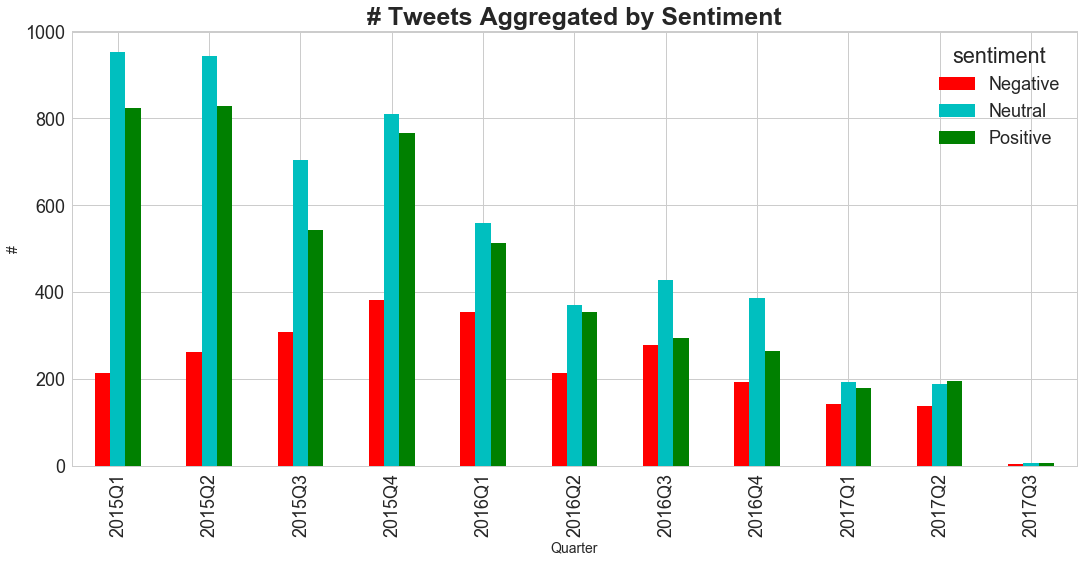

In [50]:
count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)].groupby(['quarter_cohort', 'sentiment'])
                              .size().unstack().fillna(0).
                              plot(figsize=(18, 8), kind='bar', width=0.5, color=['r', 'c', 'g']));
plt.title('# Tweets Aggregated by Sentiment', fontweight='bold', fontsize=25); 
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_counts_quarter.png')
#fix colours

While the number of tweets by Trump has decreased in general, the proportion of negative tweets has gone up, and more so, after he was elected as the president. Let us now look at how these tweets were perceived by the public. We will use the total number of retweets and likes (favorited) as a metric.

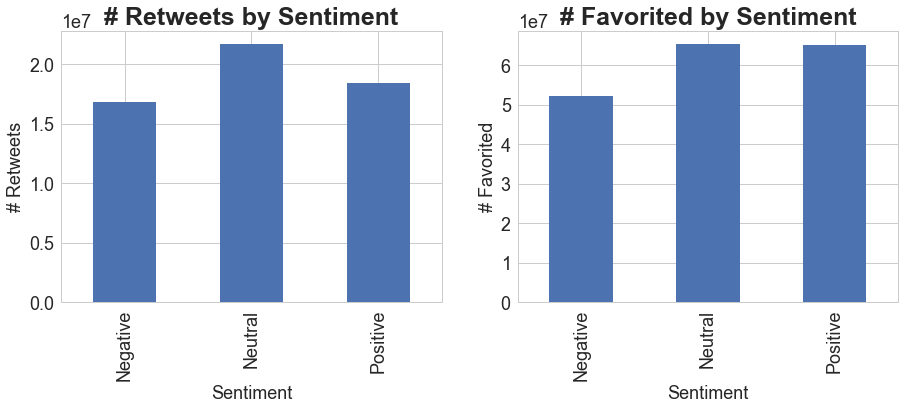

In [51]:
fig = plt.figure()
ax = fig.add_subplot(121)
retweet_count_by_sentiment = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                              .groupby('sentiment')['retweet_count']
                              .sum().plot(kind='bar', figsize=(18,5)))
plt.title('# Retweets by Sentiment', fontweight='bold', fontsize=25); 
plt.xlabel('Sentiment', fontsize=18); plt.ylabel('# Retweets', fontsize=18);

ax = fig.add_subplot(122)
favorited_count_by_sentiment = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                                .groupby('sentiment')['favorite_count']
                                .sum().plot(kind='bar', figsize=(15,5)))
#count_by_sentiment.plot(figsize=(10, 6), kind='bar', **plots_args);
plt.title('# Favorited by Sentiment', fontweight='bold', fontsize=25); 
plt.xlabel('Sentiment', fontsize=18); plt.ylabel('# Favorited', fontsize=18);
plt.savefig(FIGURE_FOLDER + 'sentiment_retweet_favorited.png')

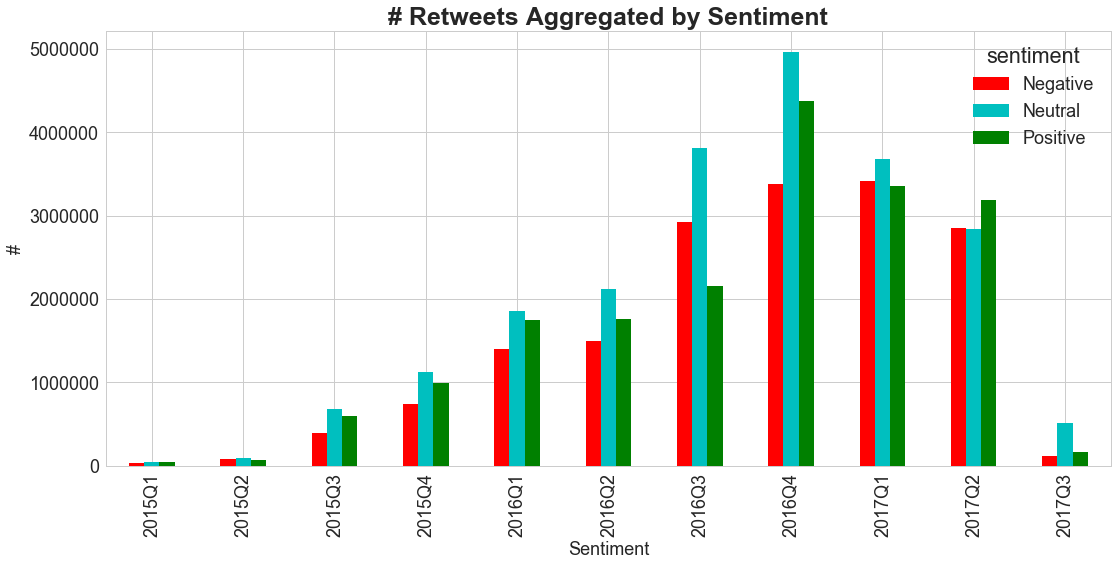

In [53]:
retweet_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                                      .groupby(['quarter_cohort', 'sentiment'])['retweet_count']
                                      .sum().unstack().plot(figsize=(18, 8), kind='bar', color=['r', 'c', 'g']))
plt.title('# Retweets Aggregated by Sentiment', fontweight='bold', fontsize=25); 
plt.xlabel('Sentiment', fontsize=18); 
plt.ylabel('#', fontsize=18);
plt.savefig(FIGURE_FOLDER + 'sentiment_retweets_quarter.png')

It is interesting to note that while the total number of negative tweets is only about ~20% in total, the number of retweets and favorited/likes are almost similar across the three categories of sentiments. This could be indicative of the fact that people are more gullible and supportive towards negative tweets by Trump.

### Sentiment-Source Analysis

Since we are aware that Trump personally uses Android for tweeting, it would be interesting to analyse the statistics of sentiments in tweets based on the source.

In [54]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False).index)

In [55]:
top_devices

Index(['Twitter for Android', 'Twitter Web Client', 'Twitter for iPhone',
       'TweetDeck', 'TwitLonger Beta', 'Instagram', 'Facebook',
       'Twitter for BlackBerry', 'Twitter Ads', 'Mobile Web (M5)',
       'Twitlonger', 'Twitter for iPad', 'Media Studio', 'Twitter QandA',
       'Vine - Make a Scene', 'Periscope', 'Neatly For BlackBerry 10',
       'Twitter Mirror for iPad', 'Twitter for Websites'],
      dtype='object', name='source')

Since we are aware that Trump personally uses Android for tweeting, it would be interesting to analyse the statistics of sentiments in tweets based on the source.

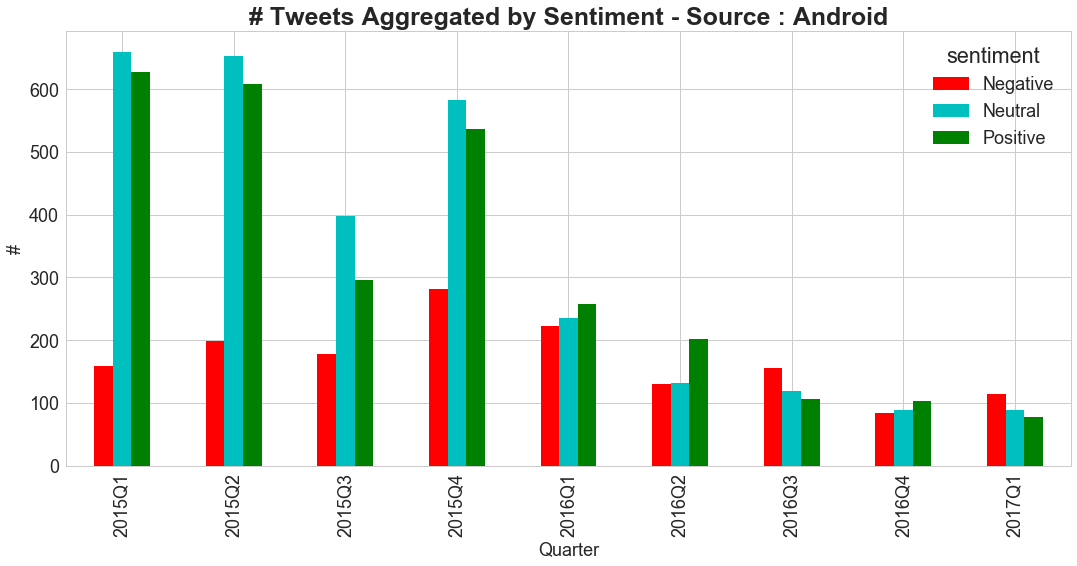

In [56]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:3].index)

#devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
pos_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)][df['source'].apply(lambda x: x == top_devices[0])]
                                  .groupby(['quarter_cohort', 'sentiment'])
                                  .size().unstack().plot(figsize=(18, 8), kind='bar', color=['r', 'c', 'g']))

plt.title('# Tweets Aggregated by Sentiment - Source : Android', fontweight='bold', fontsize=25); 
plt.xlabel('Quarter', fontsize=18); plt.ylabel('#', fontsize=18);
plt.savefig(FIGURE_FOLDER + 'sentiment_android_quarter.png')
#generate charts for each device showing distribution of tweets based on sentiment

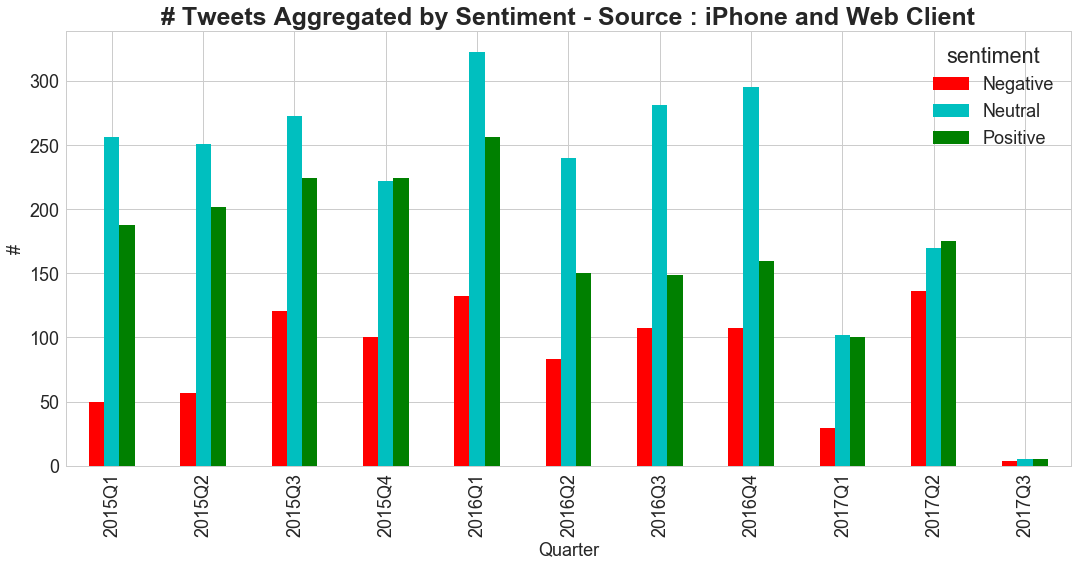

In [58]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:3].index)

#devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
pos_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)][df['source'].apply(lambda x: x in top_devices[1:3])]
                                  .groupby(['quarter_cohort', 'sentiment'])
                                  .size().unstack().plot(figsize=(18, 8), kind='bar', color=['r', 'c', 'g']))

plt.title('# Tweets Aggregated by Sentiment - Source : iPhone and Web Client', fontweight='bold', fontsize=25); 
plt.xlabel('Quarter', fontsize=18); plt.ylabel('#', fontsize=18);
plt.savefig(FIGURE_FOLDER + 'sentiment_nonandroid_quarter.png')
#generate charts for each device showing distribution of tweets based on sentiment

It is not surprising that compared to sources other than itself, tweets from Android has greater proportion of negative tweets.

# Impact Analysis

## Sensational Tweets

Lets look at the most sensational tweets based on various parameters like number of retweets, increase in the number of followers, etc.

### by retweet count

In [61]:
sensa = df.sort_values(by='retweet_count', ascending=False)
HTML(sensa[['text', 'retweet_count', 'source', 'sentiment']].head(10).to_html())

,text,retweet_count,source,sentiment
1291,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,369530,Twitter for iPhone,Neutral
2578,TODAY WE MAKE AMERICA GREAT AGAIN!,344806,Twitter for Android,Positive
2566,Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never be...,220796,Twitter for Android,Neutral
4401,"How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ",168765,Twitter for iPhone,Neutral
2340,"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",141853,Twitter for Android,Negative
28741,The electoral college is a disaster for a democracy.,141644,Twitter Web Client,Negative
1524,Despite the constant negative press covfefe,127507,Twitter for iPhone,Negative
4027,The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails.,120661,Twitter Web Client,Neutral
28773,The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive.,104633,Twitter Web Client,Neutral
2514,Fidel Castro is dead!,99483,Twitter for Android,Negative


### by favorited count

In [62]:
sensa = df.sort_values(by='favorite_count', ascending=False)
HTML(sensa[['text', 'favorite_count', 'source', 'sentiment']].head(10).to_html())

,text,favorite_count,source,sentiment
2566,Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never be...,633253,Twitter for Android,Neutral
1291,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,605098,Twitter for iPhone,Neutral
2578,TODAY WE MAKE AMERICA GREAT AGAIN!,573283,Twitter for Android,Positive
2177,"Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.",390826,Twitter for Android,Neutral
2340,"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",350860,Twitter for Android,Negative
4401,"How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ",297281,Twitter for iPhone,Neutral
2183,"THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4",289942,Twitter for iPhone,Positive
2194,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,268372,Twitter for Android,Neutral
2089,"What an amazing comeback and win by the Patriots. Tom Brady, Bob Kraft and Coach B are total winners. Wow!",267584,Twitter for Android,Positive
1497,"Whatever the United States can do to help out in London and the U. K., we will be there - WE ARE WITH YOU. GOD BLESS!",266026,Twitter for iPhone,Positive


### by increase in # followers

In [64]:
df_sorted = df.sort_values(by='created_at')
df_sorted['increase_followers'] = df_sorted['user.followers_count'] - df_sorted['user.followers_count'].shift(-1)

In [65]:
HTML(df_sorted.sort_values(by='increase_followers', ascending=False)[['text', 'sentiment', 'source', 'increase_followers']].head(10).to_html())

,text,sentiment,source,increase_followers
2157,"of jobs and companies lost. If Mexico is unwilling to pay for the badly needed wall, then it would be better to cancel the upcoming meet...",Negative,Twitter for Android,11588634.0
2142,"Today, we remember the crew of the Space Shuttle Challenger, 31 years later. #NeverForget https://t.co/OhshQsFRfl",Neutral,Twitter for iPhone,11244906.0
2092,I have instructed Homeland Security to check people coming into our country VERY CAREFULLY. The courts are making the job very difficult!,Neutral,Twitter for Android,9988920.0
2087,"I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!",Negative,Twitter for Android,9847934.0
2082,"The threat from radical Islamic terrorism is very real, just look at what is happening in Europe and the Middle-East. Courts must act fast!",Negative,Twitter for Android,9754067.0
2541,I worked hard with Bill Ford to keep the Lincoln plant in Kentucky. I owed it to the great State of Kentucky for their confidence in me!,Positive,Twitter for Android,9644901.0
2051,"I am so proud of my daughter Ivanka. To be abused and treated so badly by the media, and to still hold her head so high, is truly wonder...",Positive,Twitter for Android,9243027.0
2008,Join me at 11:00am:\nWatch here: https://t.co/veqKmsGAwf https://t.co/UzndIjIqjM,Neutral,Twitter for iPhone,8763501.0
2002,"Will be having many meetings this weekend at The Southern White House. Big 5:00 P.M. speech in Melbourne, Florida. A lot to talk about!",Neutral,Twitter for Android,8697327.0
1998,HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!,Positive,Twitter for Android,8559668.0


### by decrease in # followers

In [67]:
HTML(df_sorted.sort_values(by='increase_followers', ascending=True)[['text', 'sentiment', 'source', 'increase_followers']].head(10).to_html())

,text,sentiment,source,increase_followers
2156,"Spoke at the Congressional @GOP Retreat in Philadelphia, PA. this afternoon w/ @VP, @SenMajLeader, @SpeakerRyan. Th… https://t.co/s4sTbS...",Neutral,Twitter for iPhone,-11588588.0
2141,I will be interviewed by @TheBrodyFile on @CBNNews tonight at 11pm. Enjoy!,Positive,Twitter for iPhone,-11244954.0
3820,"""@RealJamesWoods: Without absolutely OWNING the liberal media, HillaryClinton wouldn't stand a chance. #VoterFraud and #MSM her only ho...",Neutral,Twitter for Android,-10384522.0
2091,I will be interviewed by @oreillyfactor at 4:00 P.M. (prior to the #SuperBowl Pre-game Show) on Fox Network. Enjoy!,Positive,Twitter for Android,-9988916.0
2086,Will be interviewed on @oreillyfactor tonight at 8:00 P.M.,Neutral,Twitter for Android,-9847973.0
2081,"I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!",Negative,Twitter for Android,-9754043.0
2540,"RT @transition2017: President-elect Trump announces selections for Attorney General, National Security Advisor, CIA Director. More here:...",Neutral,Twitter for iPhone,-9644908.0
2050,"Playef golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!",Positive,Twitter for Android,-9243042.0
2007,"The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more) is not my enemy, it is the enemy of the American people. SICK!",Negative,Twitter for Android,-8763491.0
2001,"Getting ready to leave for Melbourne, Florida. See you all soon!",Neutral,Twitter for Android,-8697300.0


# Temporal analysis

## Trump - The night owl

Being an early riser has always been associated as a quality of success. While, yes, the early birds do catch some worms, night owls have perks of their own.

In [15]:
df['source'].unique()

array(['Twitter for iPhone', 'Media Studio', 'Twitter Ads',
       'Twitter Web Client', 'Twitter for Android', 'Periscope',
       'Twitter for iPad', 'Instagram', 'Mobile Web (M5)',
       'Twitter Mirror for iPad', 'Twitter QandA', 'Facebook',
       'Twitter for BlackBerry', 'Neatly For BlackBerry 10',
       'Twitter for Websites', 'Twitlonger', 'Vine - Make a Scene',
       'TwitLonger Beta', 'TweetDeck'], dtype=object)

In [16]:
#Choosing only the tweets he personally tweeted
df_filt = df[df['source'] == 'Twitter for Android']

#Choosing the time slot between midnight and 3:59 AM (UTC correction)
df_filtered = df_filt[df_filt['created_at'].dt.hour>=5]
df_filtered = df_filtered[df_filtered['created_at'].dt.hour<9]

In [17]:
#Assigning a value signifying when did he exactly tweet during those four hours
df_filtered['night'] = df_filtered['created_at'].dt.second + 60 * df_filtered['created_at'].dt.minute + 3600 * df_filtered['created_at'].dt.hour

df_filtered.set_index('created_at', inplace=True)
df_filtered = df_filtered['night']

In [18]:
df_filtered.head(n = 10)

created_at
2016-12-04 05:13:58    18838
2016-09-30 07:20:02    26402
2016-09-27 05:18:10    19090
2016-09-17 05:53:09    21189
2016-09-10 06:15:08    22508
2016-09-10 05:57:59    21479
2016-09-10 05:47:11    20831
2016-08-20 05:02:57    18177
2016-07-30 06:59:41    25181
2016-06-03 05:24:28    19468
Name: night, dtype: int64

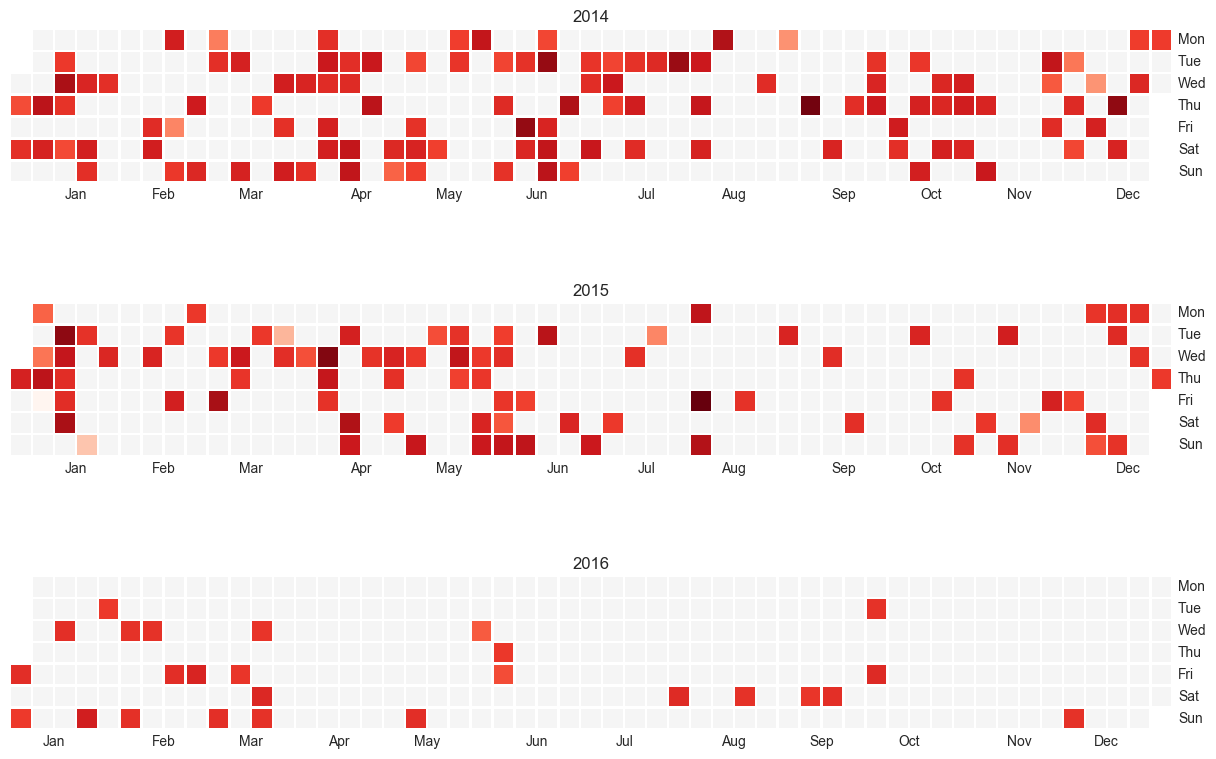

In [21]:
df_norm = (df_filtered - df_filtered.mean()) / (df_filtered.max() - df_filtered.min())

#Plotting a Calendar heatmap, where red intensity shows lateness in night (from a scale 0000 hours to 0359 hours)
fig, ax = plt.subplots(3, 1, figsize=(15,10))
ax[0].set_title('2014')
ax[1].set_title('2015')
ax[2].set_title('2016')
calmap.yearplot(df_norm, year = 2014, cmap = 'Reds', ax = ax[0], daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
calmap.yearplot(df_norm, year = 2015, cmap = 'Reds', ax = ax[1], daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
calmap.yearplot(df_norm, year = 2016, cmap = 'Reds', ax = ax[2], daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
fig.savefig('calendar_heatmap.png')

We can see that in the months leading upto him declaring his candidacy and also, during the entire election campaign, Trump was an active night owl, tweeting almost everyday after midnight.

However, there was a considerable once the campaign got over and he assumed his responsibilities of being President.

In [22]:
#Next, we will try to plot the number of times he tweets during those hours

#Giving a count of 1 to each latenight tweet
df_filtered[:] = 1

#Grouping them by day
df_filtered = df_filtered.groupby(pd.TimeGrouper(freq='D')).sum()

df_filtered.fillna(0, inplace=True)

In [23]:
df_filtered.head(n = 20)

created_at
2013-02-20     2.0
2013-02-21     0.0
2013-02-22     0.0
2013-02-23     0.0
2013-02-24     0.0
2013-02-25     1.0
2013-02-26     0.0
2013-02-27    19.0
2013-02-28     0.0
2013-03-01     0.0
2013-03-02     3.0
2013-03-03     0.0
2013-03-04     0.0
2013-03-05     0.0
2013-03-06     0.0
2013-03-07     1.0
2013-03-08     1.0
2013-03-09     0.0
2013-03-10     0.0
2013-03-11     0.0
Freq: D, Name: night, dtype: float64

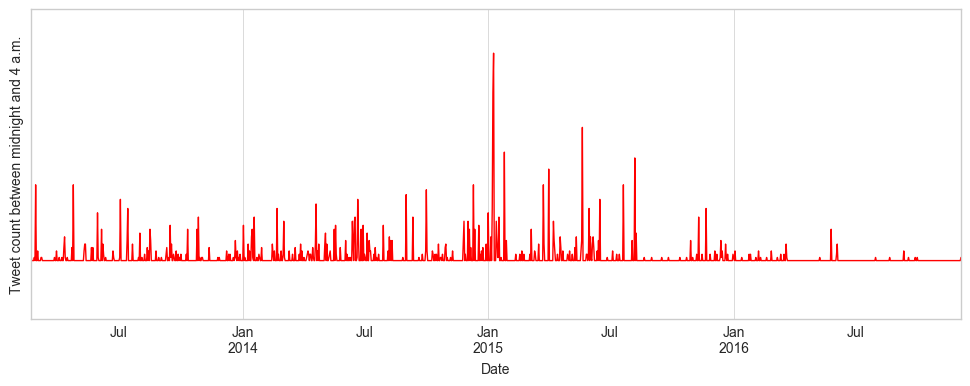

In [24]:
#Normalizing the count data
df_norm = (df_filtered - df_filtered.mean()) / (df_filtered.max() - df_filtered.min())

#Plotting his nocturnal cycle
f,ax=plt.subplots()
ax = np.exp(df_norm).plot(kind = 'line', figsize = (12,4), yticks = [], color = 'r')
ax.set_xlabel('Date')
ax.set_ylabel('Tweet count between midnight and 4 a.m.');
ax.xaxis_date()
f.savefig('timeline_latenight_tweetcount')

This visualization is again, a good representation of the sudden spike we see in his tweeting activity since 2015.

Let's do a brief topic analysis :

In [39]:
def topic_viz1(df, method, num_topics, num_words):
    
    cohorts = df['quarter_cohort'].unique()[0:-7]
    #cohorts = df['quarter_cohort'].unique()[0:-7]
    
    #f, ax = plt.subplots(6, 5, figsize=(20, 20))
    f, ax = plt.subplots(2, 5, figsize=(20, 6))
    #positions = np.array(range(30)).reshape(6, 5)
    positions = np.array(range(10)).reshape(2, 5)
    
    models = []
    
    for i, quarter in tqdm(enumerate(cohorts)):
        
        pos = np.where(positions == i)
        
        start_date = quarter.start_time
        end_date = quarter.end_time
        
        model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
        models.append(model)
        
        wordle = create_wordle(model)
        
        freq = Counter(wordle)
        
        #mask = np.array(Image.open("trump.jpg"))
        cloud = WordCloud(width=1640, height=1280, max_words=16).fit_words(freq);
        
        ax[pos[0][0], pos[1][0]].imshow(cloud);
        ax[pos[0][0], pos[1][0]].set_title('Quarter: {}'.format(quarter))
        ax[pos[0][0], pos[1][0]].axis('off')
    
    f.savefig('WordcloudTopicTimeFilter.png')
    return models

In [40]:
df_filt = df[df['source'] == 'Twitter for Android']

#Choosing the time slot between midnight and 3:59 AM
df_filtered = df_filt[df_filt['created_at'].dt.hour<4]

10it [00:18,  1.86s/it]


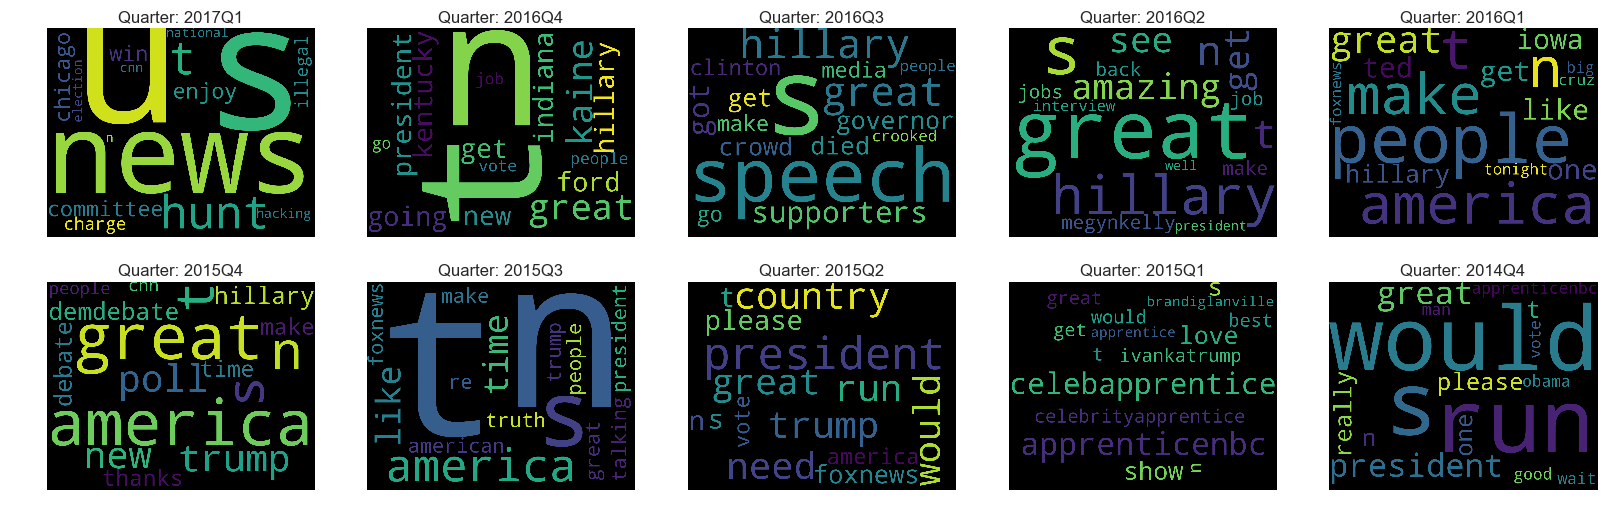

In [41]:
num_topics = 3
num_words = 8
method = 'lda'
models = topic_viz1(df_filtered, method, num_topics, num_words)